In [45]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_classif

In [46]:
import warnings
warnings.simplefilter("ignore")

# LOAD DATA

In [47]:
def load_noise_data(FILIP_PATH,noise_level,no_of_words,which):
    data = [i for i in range(no_of_words)]
    for i in range(1, no_of_words+1):
        file_name = "word"+str(i-1)+"_"+which+"_"+noise_level+".wav"
        y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
        data[i-1] = y
    return data

In [48]:
DATA_PATH = "BazaNoise/"
FILIP_PATH = DATA_PATH + "wordsFilipNoise/"
SEB_PATH = DATA_PATH + "wordsSebastianNoise/"
MARCIN_PATH = DATA_PATH + "wordsMarcinNoise/"
PROF_PATH = DATA_PATH + "wordsProfessorNoise/"
no_of_words = 30
prefixes = ["F","S","M","L"]
Fs = 48000
labelsF = np.zeros(no_of_words)
labelsS = np.zeros(no_of_words)+1
labelsM = np.zeros(no_of_words)+2
labelsL = np.zeros(no_of_words)+3
labels = np.concatenate((labelsF, labelsS,labelsM,labelsL))

## Functions to get mfcc features

In [49]:
def get_mfcc_mean_features(data,no_of_words, mfcc_features_no):
    mfcc = [i for i in range(no_of_words)]
    mfcc_delta = [i for i in range(no_of_words)]
    mfcc_delta2 = [i for i in range(no_of_words)]

    for i, word in enumerate(data):
        mfcc[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
        mfcc_delta[i] = librosa.feature.delta(word)
        mfcc_delta2[i] =  librosa.feature.delta(word, order=2)

    mfcc_mean = np.zeros((no_of_words,mfcc_features_no))
    for i in range(no_of_words):
        mfcc_mean[i,0:mfcc_features_no] = np.mean(mfcc[i],axis=1)
    
    return mfcc_mean

def get_mfcc_features(data,mfcc_features_no):
    mfcc = [i for i in range(no_of_words)]
    mfcc_delta = [i for i in range(no_of_words)]
    mfcc_delta2 = [i for i in range(no_of_words)]

    for i, word in enumerate(data):
        mfcc[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
        mfcc_delta[i] = librosa.feature.delta(word)
        mfcc_delta2[i] =  librosa.feature.delta(word, order=2)
        
    return mfcc

# Functions to get spectal features

In [50]:
def get_spectral_mean_features(data, no_of_words,spectral_features_no = 4):
    spectral_features = [i for i in range(no_of_words)]
    sr = 48000
    for i, word in enumerate(data):
        spectral_features_vector = np.zeros(4)
        spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
        spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
        spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
        spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
        spectral_features[i] = spectral_features_vector
    return spectral_features

## Functions to get zero crossing

In [51]:
def get_zero_crossing_features(data, no_of_words) :
    zcr_mean = np.zeros((no_of_words, 1))
    for i in range(no_of_words):
        zcr_mean[i, 0] = np.mean(data[i])
    return zcr_mean

## Functions to get chroma features

In [52]:
def get_mean_chroma_features(data, chroma_types):

    chroma_stft = []
    chroma_cqt = []
    chroma_cens = []
    chroma_vqt = []

    sr = 48000

    for audio in data:
        word_stft = chroma_types[list(chroma_types.keys())[0]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[0]]["params"])
        word_cqt = chroma_types[list(chroma_types.keys())[1]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[1]]["params"])
        word_cens = chroma_types[list(chroma_types.keys())[2]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[2]]["params"])
        word_vqt = chroma_types[list(chroma_types.keys())[3]]["func"](y=audio, sr=sr, **chroma_types[list(chroma_types.keys())[3]]["params"])


        chroma_stft.append(word_stft.mean(axis=1).flatten())
        chroma_cqt.append(word_cqt.mean(axis=1).flatten())
        chroma_cens.append(word_cens.mean(axis=1).flatten())
        chroma_vqt.append(word_vqt.mean(axis=1).flatten())

    return chroma_stft, chroma_cqt, chroma_cens, chroma_vqt

chroma_types ={
    "stft": {
        "func": librosa.feature.chroma_stft,
        "params": {},
    },
    "cqt": {
        "func": librosa.feature.chroma_cqt,
        "params": {},
    },
    "cens": {
        "func": librosa.feature.chroma_cens,
        "params": {},
    },
    "vqt": {
        "func": librosa.feature.chroma_vqt,
        "params": {"intervals": "equal"},
    }
}

# Functions to get classifier results and show confusion matrix

In [53]:
def get_clf_results(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), y_pred

def show_conf_matirx(y_test, y_pred,clf,feature ):
    cm = confusion_matrix(y_test, y_pred)
    ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]

    sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
    plt.ylabel('Prediction',fontsize=12)
    plt.xlabel('Actual',fontsize=12)
    plt.title('Confusion Matrix - ' + feature +" - "+type(clf).__name__,fontsize=16)
    plt.show()

## Classifiers

# Getting full features

In [54]:
def get_feature_vector_mfcc(words_filip,words_seb,words_marcin, words_prof, no_of_words, mfcc_features_no):
    mfcc_filip_mean = get_mfcc_mean_features(words_filip,no_of_words,mfcc_features_no)
    mfcc_seb_mean = get_mfcc_mean_features(words_seb,no_of_words,mfcc_features_no)
    mfcc_marcin_mean = get_mfcc_mean_features(words_marcin,no_of_words,mfcc_features_no)
    mfcc_prof_mean = get_mfcc_mean_features(words_prof,no_of_words,mfcc_features_no)

    feature_vector_mfcc = np.concatenate((mfcc_filip_mean, mfcc_seb_mean,mfcc_marcin_mean,mfcc_prof_mean))

    return feature_vector_mfcc

def get_feature_vector_spectral(words_filip,words_seb,words_marcin, words_prof, no_of_words,spectral_features_no):
    spectral_features_filip = get_spectral_mean_features(words_filip, no_of_words,spectral_features_no)
    spectral_features_seb = get_spectral_mean_features(words_seb, no_of_words,spectral_features_no)
    spectral_features_marcin = get_spectral_mean_features(words_marcin, no_of_words,spectral_features_no)
    spectral_features_prof = get_spectral_mean_features(words_prof, no_of_words,spectral_features_no)

    feature_vector_spectral = np.concatenate((spectral_features_filip, spectral_features_seb,spectral_features_marcin,spectral_features_prof))

    return feature_vector_spectral

def get_feature_vector_zeros(words_filip,words_seb,words_marcin, words_prof, no_of_words):
    zcr_filip  = get_zero_crossing_features(words_filip, no_of_words)
    zcr_seb    = get_zero_crossing_features(words_seb, no_of_words)
    zcr_marcin = get_zero_crossing_features(words_marcin, no_of_words)
    zcr_prof   = get_zero_crossing_features(words_prof, no_of_words)

    feature_vector_zeros = np.concatenate((zcr_filip, zcr_seb,zcr_marcin,zcr_prof))

    return feature_vector_zeros

def get_feature_vector_chroma(words_filip,words_seb,words_marcin, words_prof,chroma_types):
    chroma_filip_stft_mean, chroma_filip_cqt_mean, chroma_filip_cens_mean, chroma_filip_vqt_mean = get_mean_chroma_features(words_filip, chroma_types)
    chroma_seb_stft_mean, chroma_seb_cqt_mean, chroma_seb_cens_mean, chroma_seb_vqt_mean = get_mean_chroma_features(words_seb, chroma_types)
    chroma_marcin_stft_mean, chroma_marcin_cqt_mean, chroma_marcin_cens_mean, chroma_marcin_vqt_mean = get_mean_chroma_features(words_marcin, chroma_types)
    chroma_prof_stft_mean, chroma_prof_cqt_mean, chroma_prof_cens_mean, chroma_prof_vqt_mean = get_mean_chroma_features(words_prof, chroma_types)

    chroma_filip = np.concatenate((np.array(chroma_filip_stft_mean),np.array(chroma_filip_cqt_mean),np.array(chroma_filip_cens_mean),np.array(chroma_filip_vqt_mean)),axis=1)
    chroma_seb = np.concatenate((np.array(chroma_seb_stft_mean),np.array(chroma_seb_cqt_mean),np.array(chroma_seb_cens_mean),np.array(chroma_seb_vqt_mean)),axis=1)
    chroma_marcin = np.concatenate((np.array(chroma_marcin_stft_mean),np.array(chroma_marcin_cqt_mean),np.array(chroma_marcin_cens_mean),np.array(chroma_marcin_vqt_mean)),axis=1)
    chroma_prof = np.concatenate((np.array(chroma_prof_stft_mean),np.array(chroma_prof_cqt_mean),np.array(chroma_prof_cens_mean),np.array(chroma_prof_vqt_mean)),axis=1)

    feature_vector_chroma = np.concatenate((chroma_filip, chroma_seb,chroma_marcin,chroma_prof))

    return feature_vector_chroma


In [55]:
svm = SVC(kernel='rbf', C=1.0, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)


def get_results_per_feature(feature_vector,feature_name):
    X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=42)

    acc_score_svm, class_report_svm, y_pred_svm = get_clf_results(svm, X_train, X_test, y_train, y_test)
    acc_score_rbf, class_report_rbf, y_pred_rbf= get_clf_results(rf_clf, X_train, X_test, y_train, y_test)
    acc_score_mlp, class_report_mlp, y_pred_mlp = get_clf_results(mlp_clf, X_train, X_test, y_train, y_test)

    print(acc_score_svm, class_report_svm)
    print(acc_score_rbf, class_report_rbf)
    print(acc_score_mlp, class_report_mlp)

    show_conf_matirx(y_test, y_pred_svm,svm,feature_name)
    show_conf_matirx(y_test, y_pred_rbf,rf_clf,feature_name)
    show_conf_matirx(y_test, y_pred_mlp,mlp_clf,feature_name)
    

# Noise - 10%

In [56]:
noise_level = "N10"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.85               precision    recall  f1-score   support

         0.0       0.87      0.81      0.84        16
         1.0       0.94      0.88      0.91        17
         2.0       0.80      0.80      0.80        15
         3.0       0.79      0.92      0.85        12

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

0.7833333333333333               precision    recall  f1-score   support

         0.0       0.79      0.69      0.73    

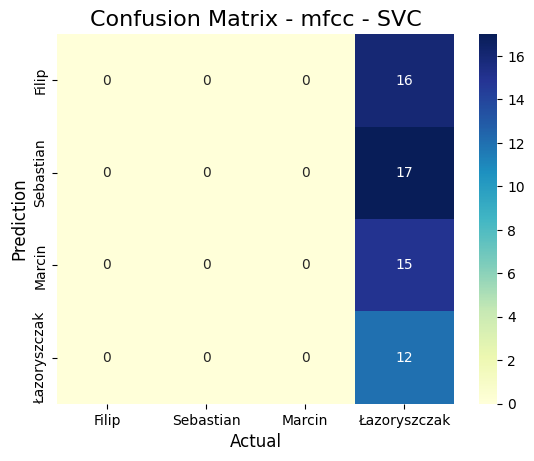

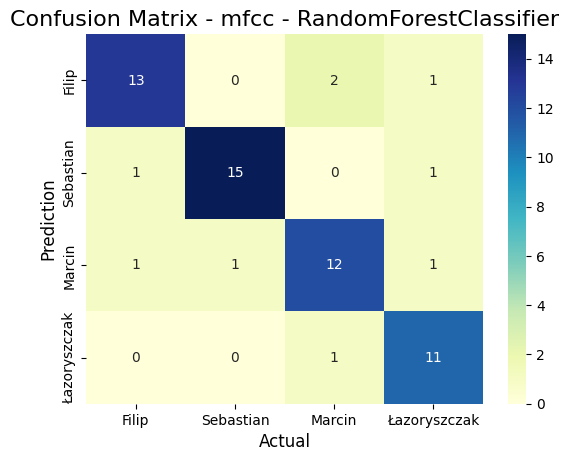

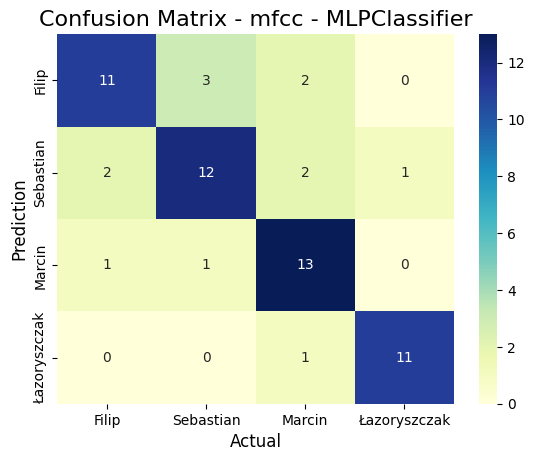

0.4166666666666667               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.30      1.00      0.46        15
         3.0       1.00      0.83      0.91        12

    accuracy                           0.42        60
   macro avg       0.33      0.46      0.34        60
weighted avg       0.28      0.42      0.30        60

0.5               precision    recall  f1-score   support

         0.0       0.36      0.50      0.42        16
         1.0       0.33      0.18      0.23        17
         2.0       0.44      0.53      0.48        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.50        60
   macro avg       0.54      0.53      0.52        60
weighted avg       0.50      0.50      0.49        60

0.31666666666666665               precision    recall  f1-score   support

         0.0       0.37      0.6

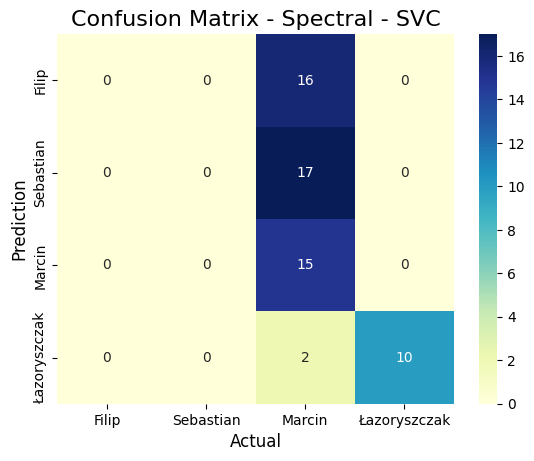

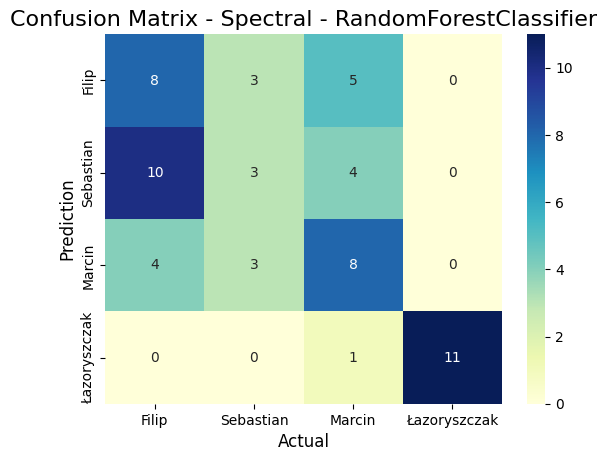

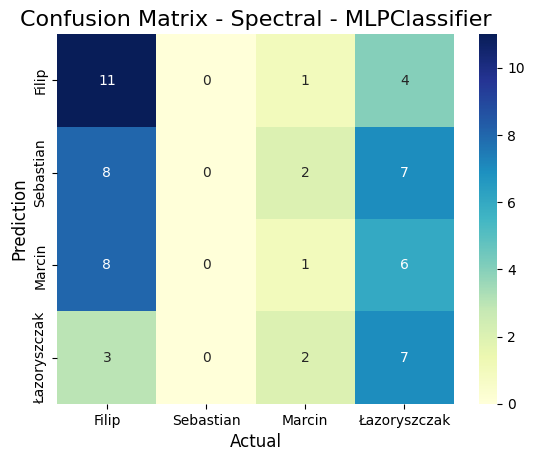

0.36666666666666664               precision    recall  f1-score   support

         0.0       0.43      0.62      0.51        16
         1.0       0.33      0.12      0.17        17
         2.0       0.33      0.27      0.30        15
         3.0       0.32      0.50      0.39        12

    accuracy                           0.37        60
   macro avg       0.35      0.38      0.34        60
weighted avg       0.36      0.37      0.34        60

0.31666666666666665               precision    recall  f1-score   support

         0.0       0.44      0.25      0.32        16
         1.0       0.28      0.29      0.29        17
         2.0       0.25      0.20      0.22        15
         3.0       0.33      0.58      0.42        12

    accuracy                           0.32        60
   macro avg       0.33      0.33      0.31        60
weighted avg       0.33      0.32      0.31        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.

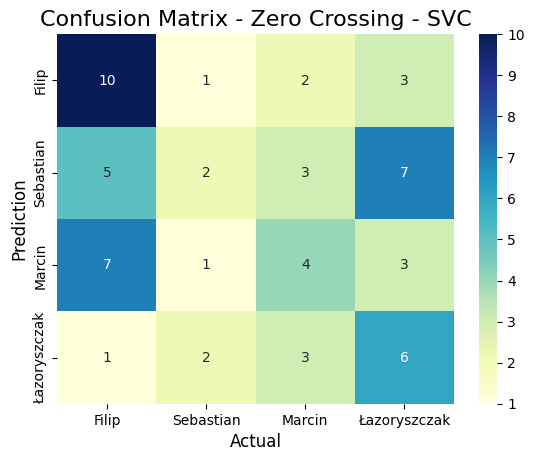

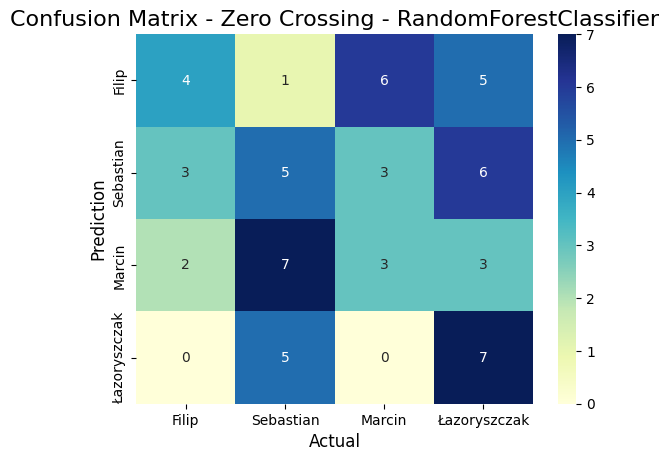

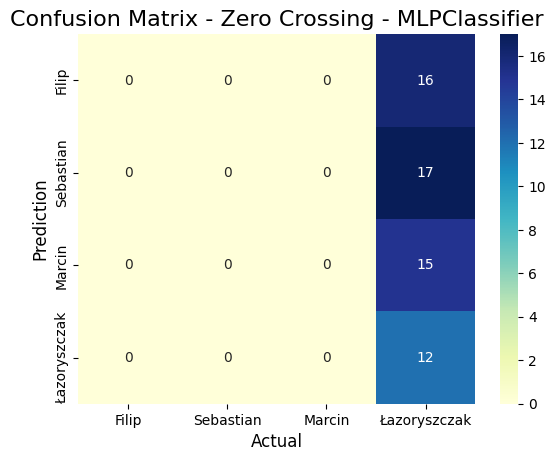

0.65               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67        16
         1.0       0.67      0.35      0.46        17
         2.0       1.00      0.80      0.89        15
         3.0       0.45      0.83      0.59        12

    accuracy                           0.65        60
   macro avg       0.69      0.67      0.65        60
weighted avg       0.70      0.65      0.65        60

0.65               precision    recall  f1-score   support

         0.0       0.71      0.62      0.67        16
         1.0       0.73      0.47      0.57        17
         2.0       1.00      0.73      0.85        15
         3.0       0.42      0.83      0.56        12

    accuracy                           0.65        60
   macro avg       0.71      0.67      0.66        60
weighted avg       0.73      0.65      0.66        60

0.75               precision    recall  f1-score   support

         0.0       0.79      0.69      0.73        16
      

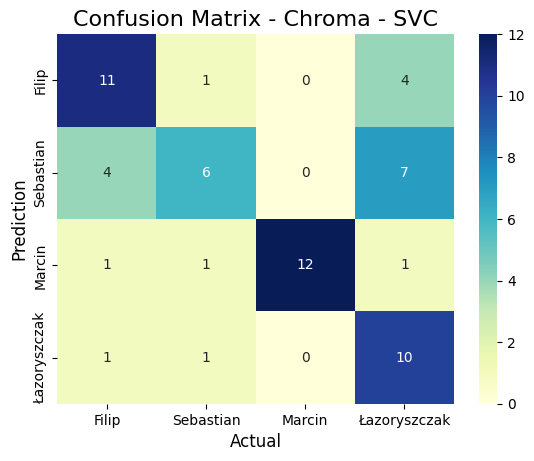

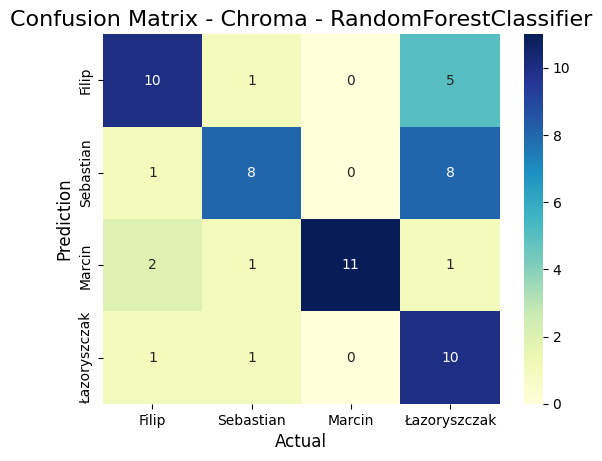

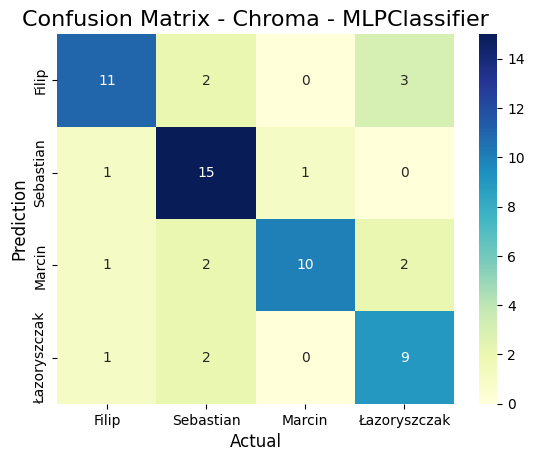

In [57]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 20%

In [58]:
noise_level = "N20"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.85               precision    recall  f1-score   support

         0.0       0.72      0.81      0.76        16
         1.0       0.81      0.76      0.79        17
         2.0       0.93      0.87      0.90        15
         3.0       1.00      1.00      1.00        12

    accuracy                           0.85        60
   macro avg       0.87      0.86      0.86        60
weighted avg       0.85      0.85      0.85        60

0.8166666666666667               precision    recall  f1-score   support

         0.0       0.79      0.69      0.73    

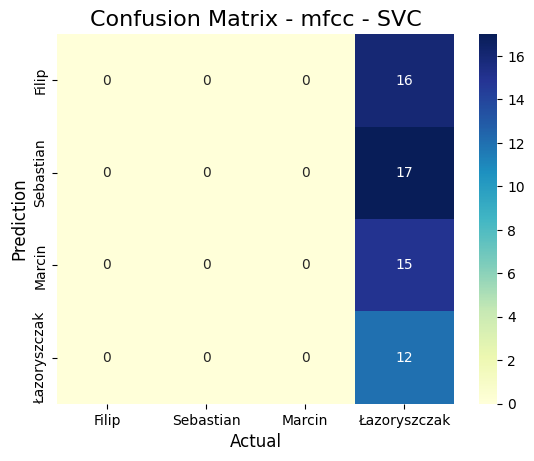

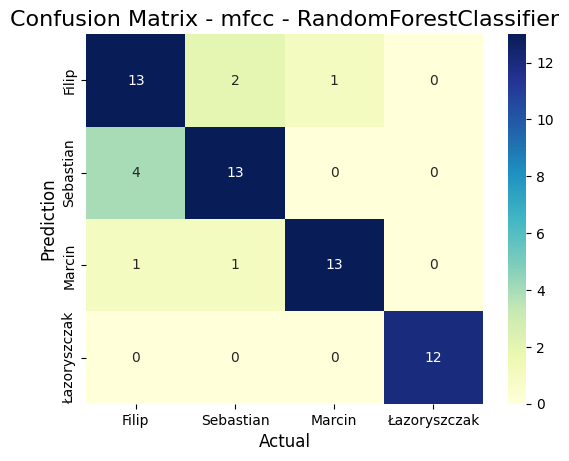

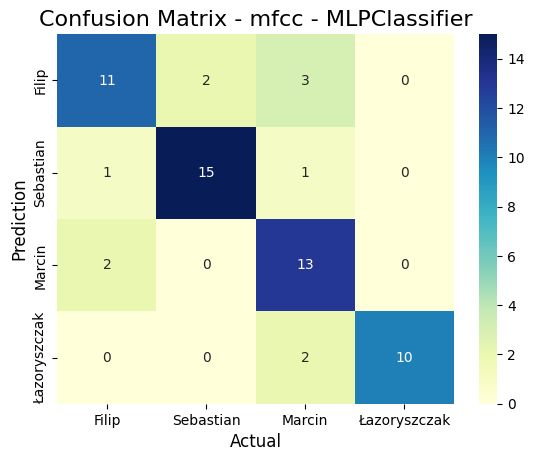

0.4166666666666667               precision    recall  f1-score   support

         0.0       0.50      0.06      0.11        16
         1.0       0.00      0.00      0.00        17
         2.0       0.39      0.93      0.55        15
         3.0       0.45      0.83      0.59        12

    accuracy                           0.42        60
   macro avg       0.34      0.46      0.31        60
weighted avg       0.32      0.42      0.28        60

0.5               precision    recall  f1-score   support

         0.0       0.31      0.31      0.31        16
         1.0       0.40      0.35      0.38        17
         2.0       0.47      0.60      0.53        15
         3.0       1.00      0.83      0.91        12

    accuracy                           0.50        60
   macro avg       0.55      0.52      0.53        60
weighted avg       0.52      0.50      0.50        60

0.21666666666666667               precision    recall  f1-score   support

         0.0       0.00      0.0

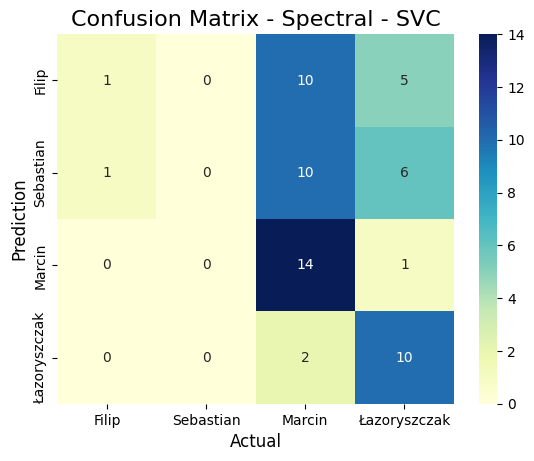

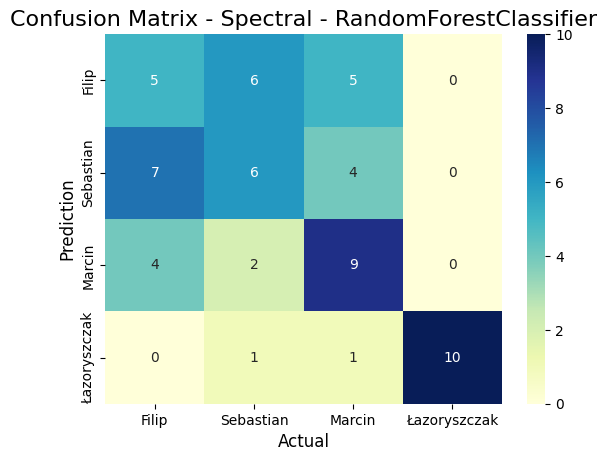

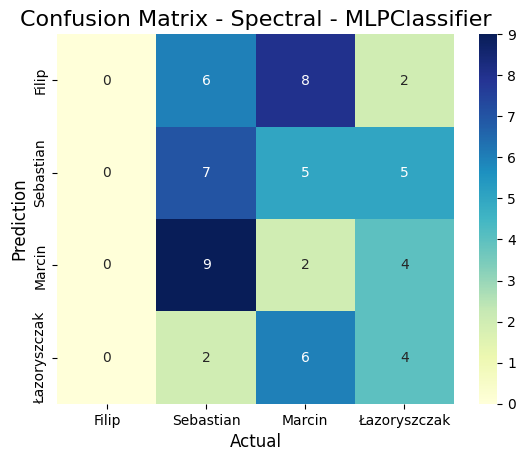

0.36666666666666664               precision    recall  f1-score   support

         0.0       0.44      0.75      0.56        16
         1.0       0.38      0.18      0.24        17
         2.0       0.50      0.07      0.12        15
         3.0       0.26      0.50      0.34        12

    accuracy                           0.37        60
   macro avg       0.40      0.37      0.31        60
weighted avg       0.40      0.37      0.31        60

0.36666666666666664               precision    recall  f1-score   support

         0.0       0.40      0.38      0.39        16
         1.0       0.39      0.41      0.40        17
         2.0       0.17      0.13      0.15        15
         3.0       0.47      0.58      0.52        12

    accuracy                           0.37        60
   macro avg       0.36      0.38      0.36        60
weighted avg       0.35      0.37      0.36        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.

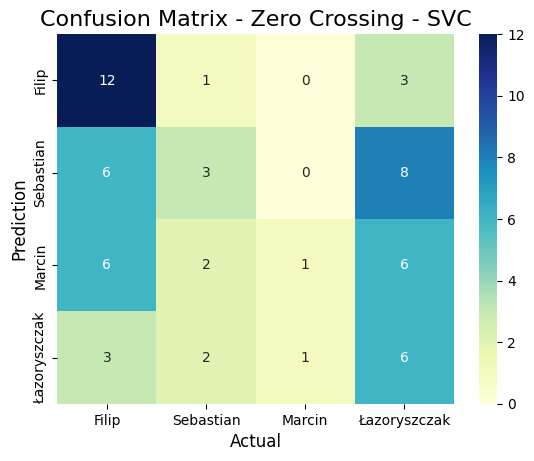

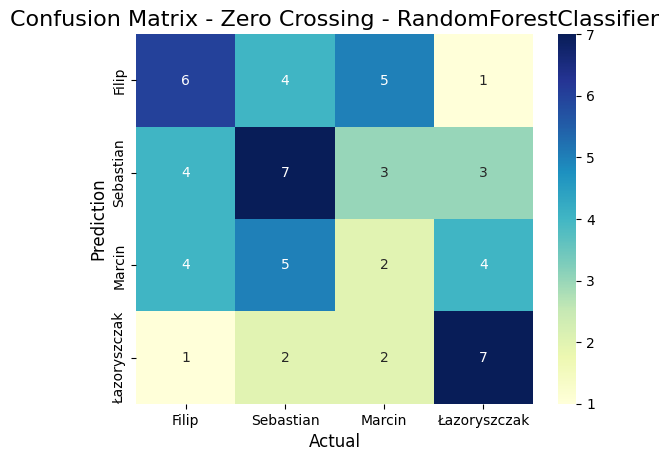

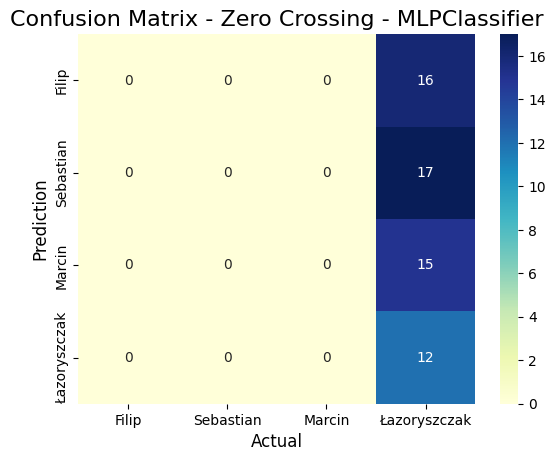

0.6666666666666666               precision    recall  f1-score   support

         0.0       0.69      0.69      0.69        16
         1.0       0.86      0.35      0.50        17
         2.0       1.00      0.80      0.89        15
         3.0       0.44      0.92      0.59        12

    accuracy                           0.67        60
   macro avg       0.75      0.69      0.67        60
weighted avg       0.76      0.67      0.67        60

0.6833333333333333               precision    recall  f1-score   support

         0.0       0.73      0.69      0.71        16
         1.0       0.78      0.41      0.54        17
         2.0       0.92      0.80      0.86        15
         3.0       0.48      0.92      0.63        12

    accuracy                           0.68        60
   macro avg       0.73      0.70      0.68        60
weighted avg       0.74      0.68      0.68        60

0.7166666666666667               precision    recall  f1-score   support

         0.0      

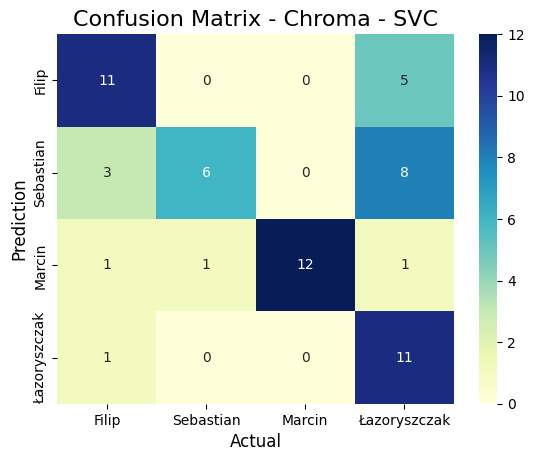

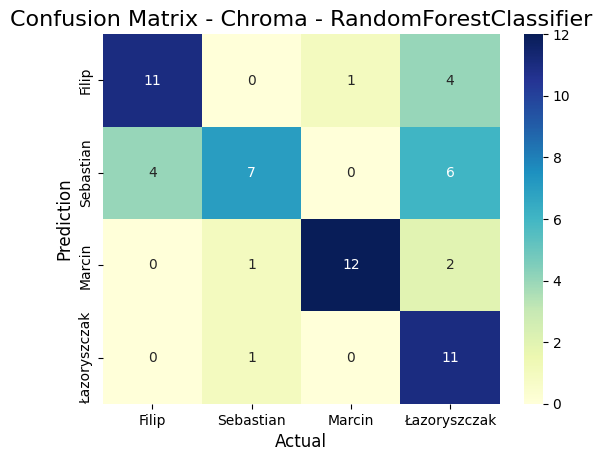

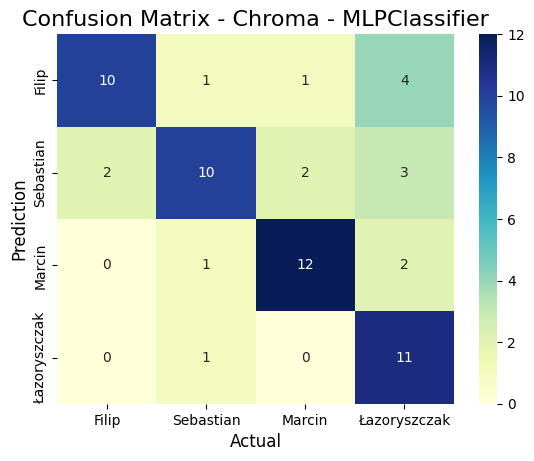

In [59]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 30 %

In [60]:
noise_level = "N30"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.7833333333333333               precision    recall  f1-score   support

         0.0       0.71      0.75      0.73        16
         1.0       0.75      0.71      0.73        17
         2.0       0.85      0.73      0.79        15
         3.0       0.86      1.00      0.92        12

    accuracy                           0.78        60
   macro avg       0.79      0.80      0.79        60
weighted avg       0.78      0.78      0.78        60

0.25               precision    recall  f1-score   support

         0.0       0.50      0.12      0.20    

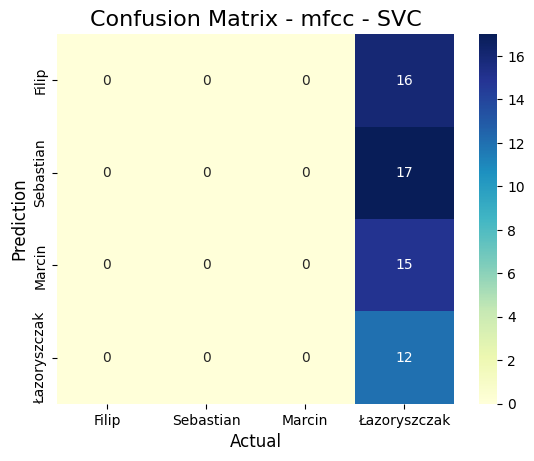

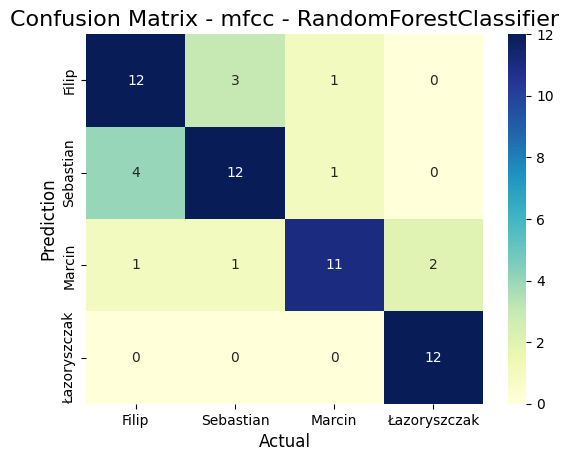

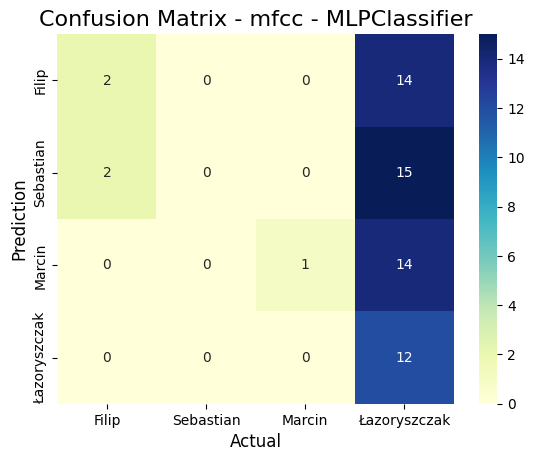

0.4               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.47      0.93      0.62        15
         3.0       0.33      0.83      0.48        12

    accuracy                           0.40        60
   macro avg       0.20      0.44      0.27        60
weighted avg       0.18      0.40      0.25        60

0.4666666666666667               precision    recall  f1-score   support

         0.0       0.39      0.56      0.46        16
         1.0       0.46      0.35      0.40        17
         2.0       0.38      0.33      0.36        15
         3.0       0.73      0.67      0.70        12

    accuracy                           0.47        60
   macro avg       0.49      0.48      0.48        60
weighted avg       0.48      0.47      0.46        60

0.25               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    

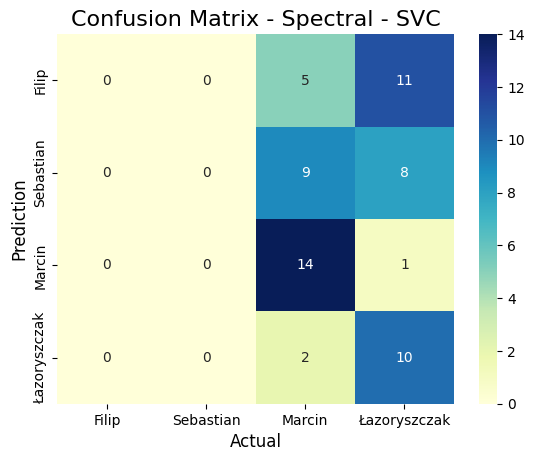

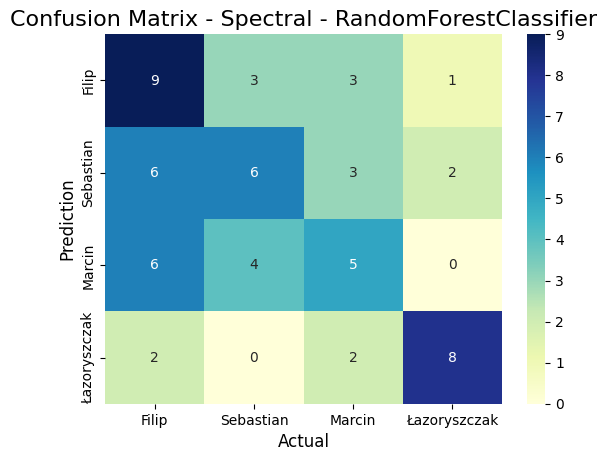

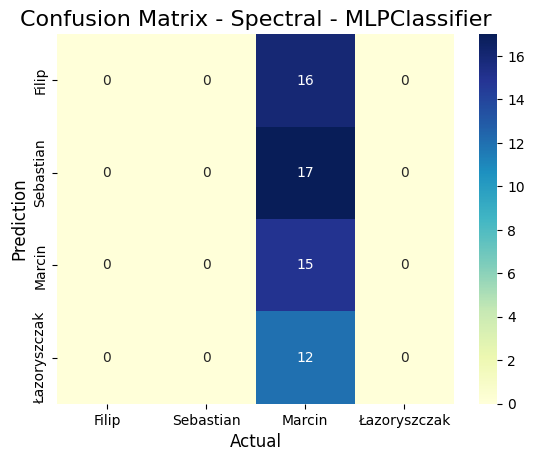

0.36666666666666664               precision    recall  f1-score   support

         0.0       0.46      0.75      0.57        16
         1.0       0.25      0.06      0.10        17
         2.0       0.30      0.20      0.24        15
         3.0       0.30      0.50      0.38        12

    accuracy                           0.37        60
   macro avg       0.33      0.38      0.32        60
weighted avg       0.33      0.37      0.31        60

0.36666666666666664               precision    recall  f1-score   support

         0.0       0.57      0.50      0.53        16
         1.0       0.35      0.35      0.35        17
         2.0       0.18      0.20      0.19        15
         3.0       0.42      0.42      0.42        12

    accuracy                           0.37        60
   macro avg       0.38      0.37      0.37        60
weighted avg       0.38      0.37      0.37        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.

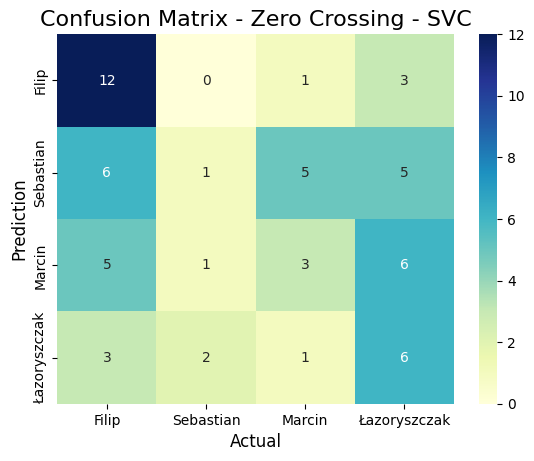

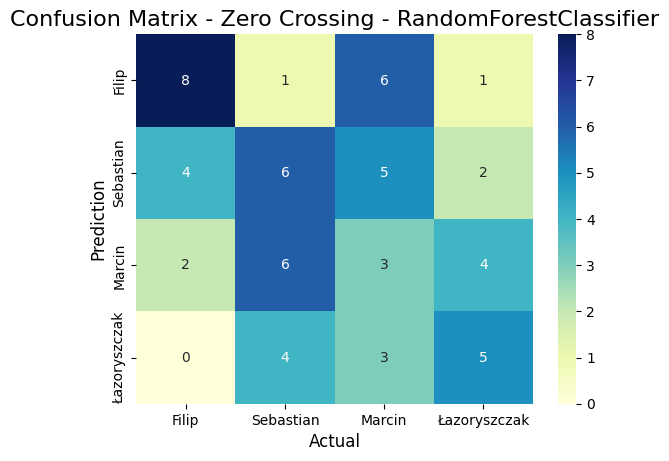

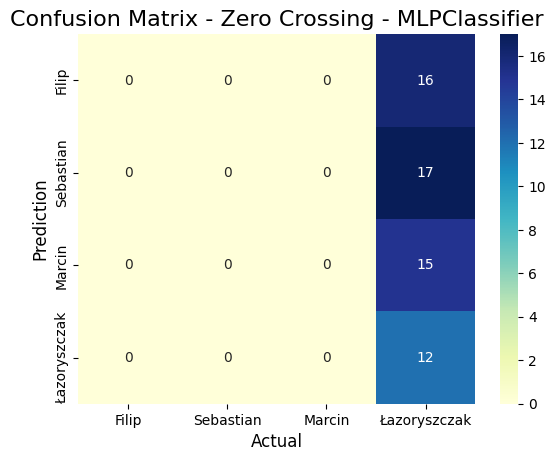

0.7333333333333333               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67        16
         1.0       1.00      0.41      0.58        17
         2.0       0.93      0.93      0.93        15
         3.0       0.57      1.00      0.73        12

    accuracy                           0.73        60
   macro avg       0.79      0.76      0.73        60
weighted avg       0.80      0.73      0.72        60

0.7               precision    recall  f1-score   support

         0.0       0.82      0.56      0.67        16
         1.0       0.62      0.47      0.53        17
         2.0       0.93      0.93      0.93        15
         3.0       0.52      0.92      0.67        12

    accuracy                           0.70        60
   macro avg       0.72      0.72      0.70        60
weighted avg       0.73      0.70      0.70        60

0.7333333333333333               precision    recall  f1-score   support

         0.0       0.79      0.69

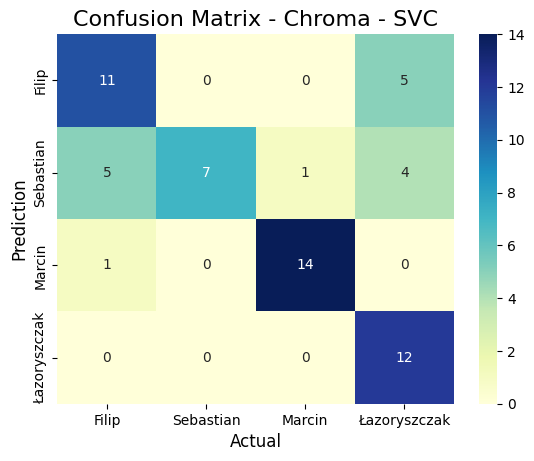

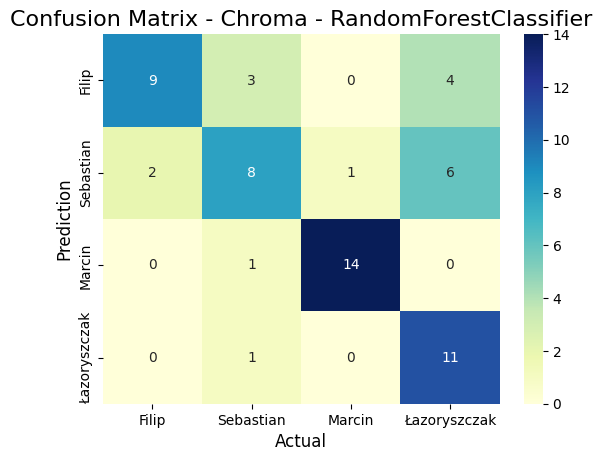

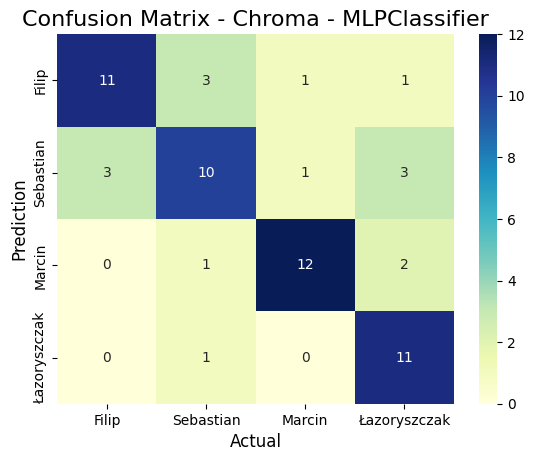

In [61]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 40%

In [62]:
noise_level = "N40"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.75               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75        16
         1.0       0.67      0.59      0.62        17
         2.0       0.71      0.80      0.75        15
         3.0       0.92      0.92      0.92        12

    accuracy                           0.75        60
   macro avg       0.76      0.76      0.76        60
weighted avg       0.75      0.75      0.75        60

0.7833333333333333               precision    recall  f1-score   support

         0.0       0.70      0.88      0.78    

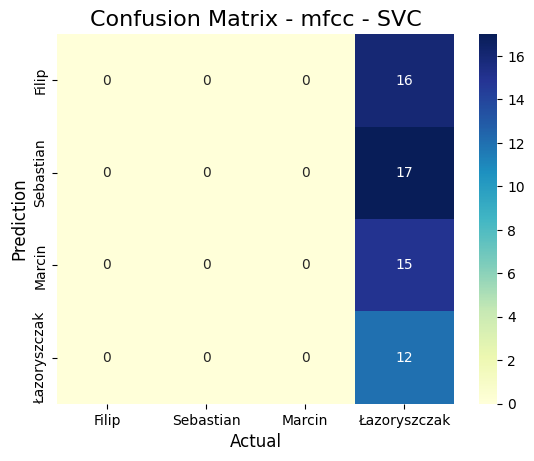

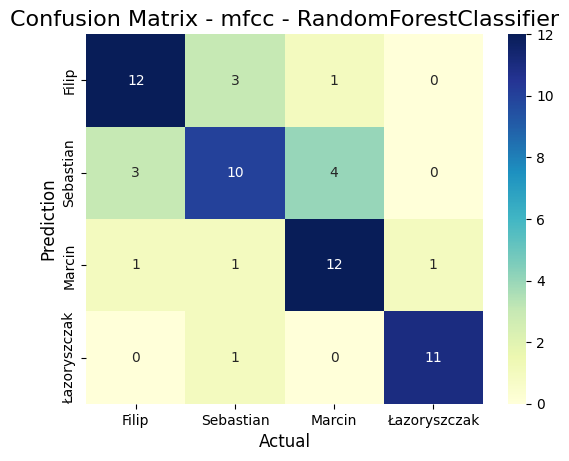

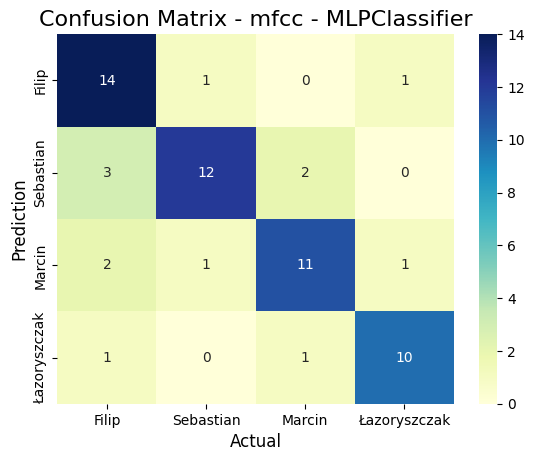

0.38333333333333336               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.59      0.87      0.70        15
         3.0       0.26      0.83      0.40        12

    accuracy                           0.38        60
   macro avg       0.21      0.43      0.28        60
weighted avg       0.20      0.38      0.26        60

0.36666666666666664               precision    recall  f1-score   support

         0.0       0.33      0.31      0.32        16
         1.0       0.33      0.24      0.28        17
         2.0       0.27      0.27      0.27        15
         3.0       0.50      0.75      0.60        12

    accuracy                           0.37        60
   macro avg       0.36      0.39      0.37        60
weighted avg       0.35      0.37      0.35        60

0.2833333333333333               precision    recall  f1-score   support

         0.0    

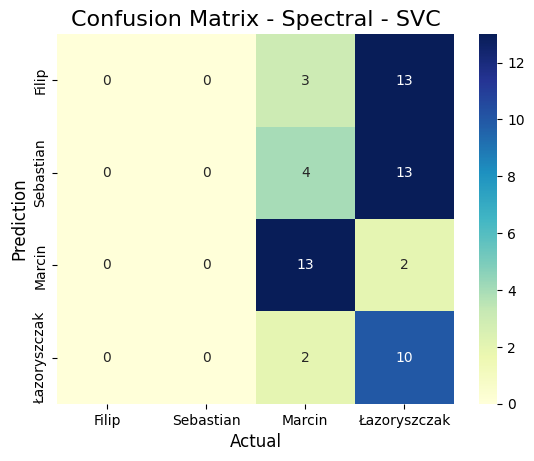

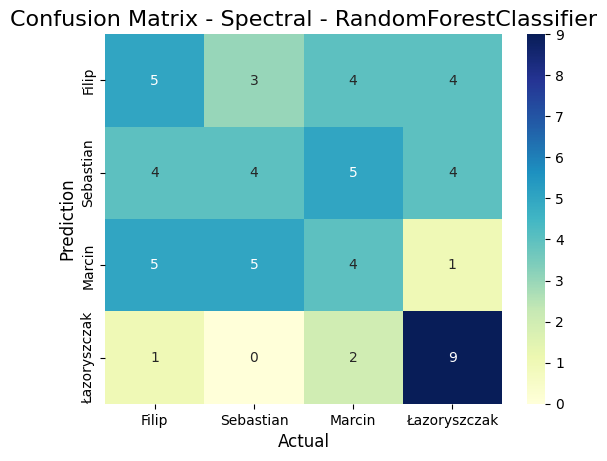

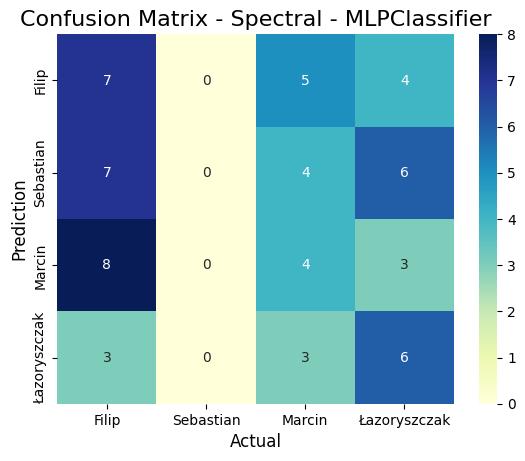

0.31666666666666665               precision    recall  f1-score   support

         0.0       0.41      0.69      0.51        16
         1.0       0.33      0.12      0.17        17
         2.0       0.00      0.00      0.00        15
         3.0       0.22      0.50      0.31        12

    accuracy                           0.32        60
   macro avg       0.24      0.33      0.25        60
weighted avg       0.25      0.32      0.25        60

0.35               precision    recall  f1-score   support

         0.0       0.33      0.38      0.35        16
         1.0       0.50      0.41      0.45        17
         2.0       0.50      0.20      0.29        15
         3.0       0.23      0.42      0.29        12

    accuracy                           0.35        60
   macro avg       0.39      0.35      0.35        60
weighted avg       0.40      0.35      0.35        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00   

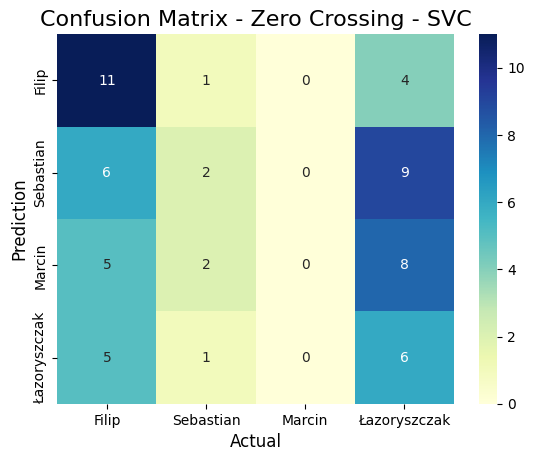

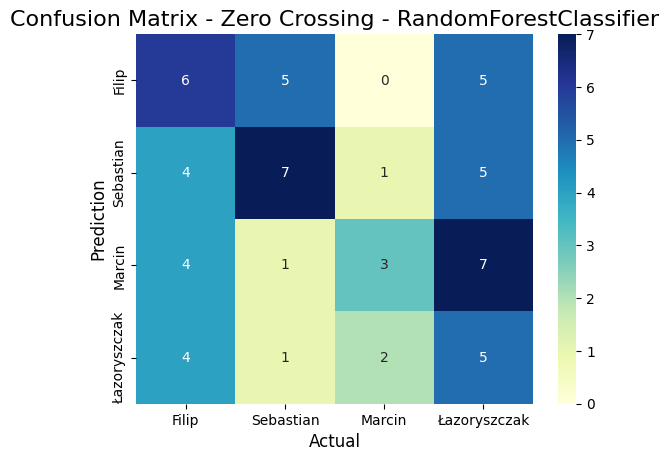

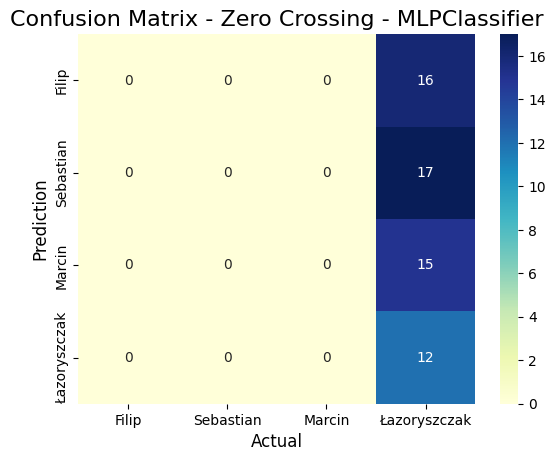

0.7666666666666667               precision    recall  f1-score   support

         0.0       0.61      0.69      0.65        16
         1.0       1.00      0.59      0.74        17
         2.0       0.93      0.87      0.90        15
         3.0       0.67      1.00      0.80        12

    accuracy                           0.77        60
   macro avg       0.80      0.79      0.77        60
weighted avg       0.81      0.77      0.77        60

0.75               precision    recall  f1-score   support

         0.0       0.67      0.62      0.65        16
         1.0       0.80      0.71      0.75        17
         2.0       0.93      0.87      0.90        15
         3.0       0.62      0.83      0.71        12

    accuracy                           0.75        60
   macro avg       0.76      0.76      0.75        60
weighted avg       0.76      0.75      0.75        60

0.75               precision    recall  f1-score   support

         0.0       0.73      0.69      0.71   

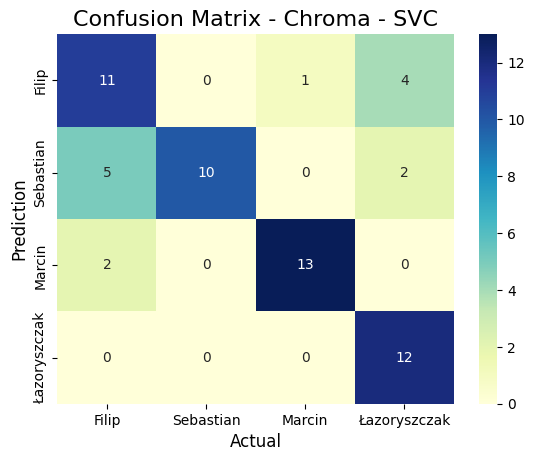

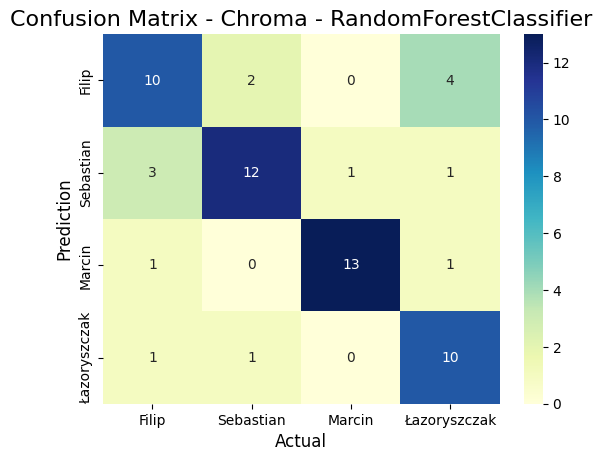

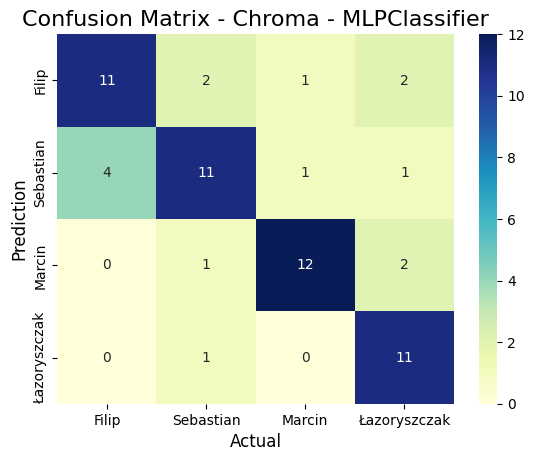

In [63]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 50%

In [64]:
noise_level = "N50"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.75               precision    recall  f1-score   support

         0.0       0.67      0.75      0.71        16
         1.0       0.64      0.53      0.58        17
         2.0       0.76      0.87      0.81        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.75        60
   macro avg       0.77      0.77      0.76        60
weighted avg       0.75      0.75      0.75        60

0.13333333333333333               precision    recall  f1-score   support

         0.0       0.29      0.25      0.27   

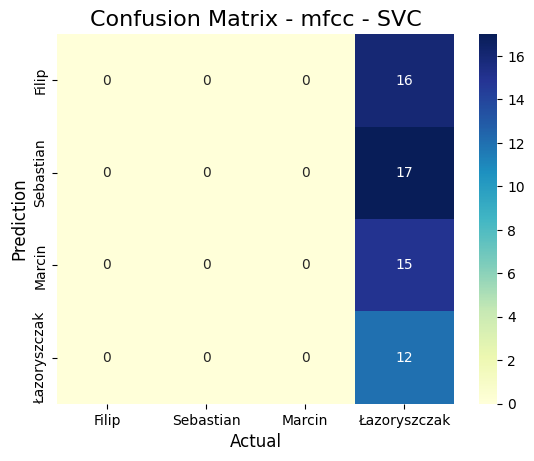

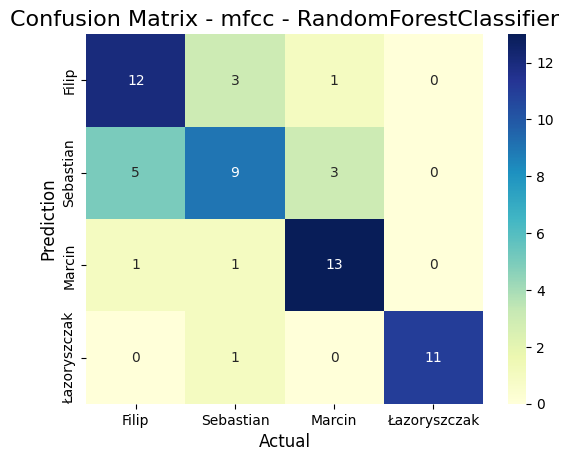

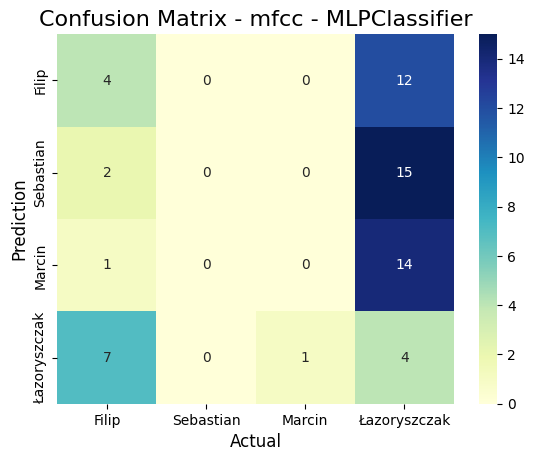

0.2833333333333333               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.64      0.47      0.54        15
         3.0       0.20      0.83      0.33        12

    accuracy                           0.28        60
   macro avg       0.21      0.33      0.22        60
weighted avg       0.20      0.28      0.20        60

0.4166666666666667               precision    recall  f1-score   support

         0.0       0.44      0.25      0.32        16
         1.0       0.41      0.53      0.46        17
         2.0       0.50      0.40      0.44        15
         3.0       0.35      0.50      0.41        12

    accuracy                           0.42        60
   macro avg       0.43      0.42      0.41        60
weighted avg       0.43      0.42      0.41        60

0.21666666666666667               precision    recall  f1-score   support

         0.0     

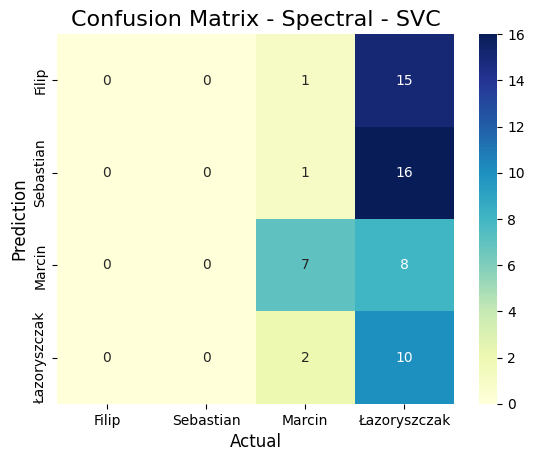

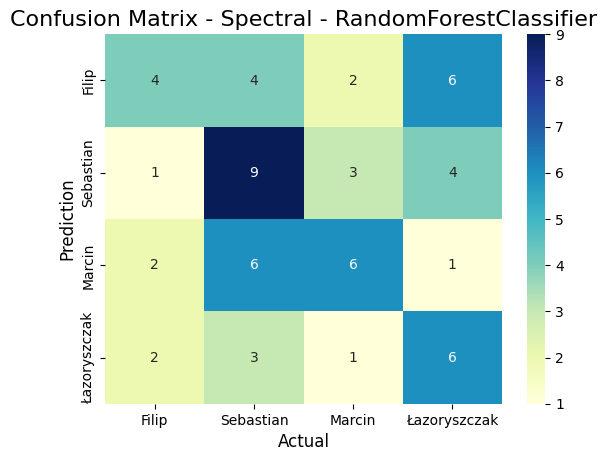

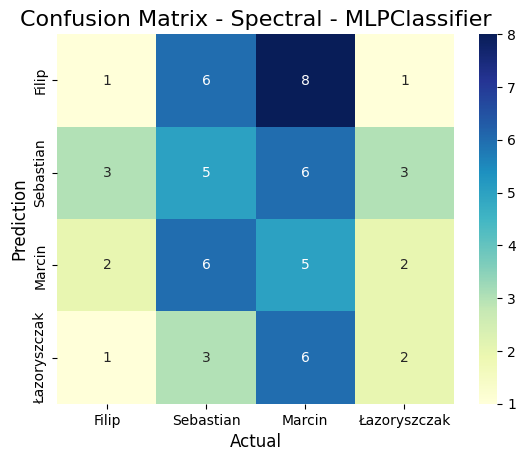

0.35               precision    recall  f1-score   support

         0.0       0.42      0.62      0.50        16
         1.0       0.45      0.29      0.36        17
         2.0       0.00      0.00      0.00        15
         3.0       0.24      0.50      0.32        12

    accuracy                           0.35        60
   macro avg       0.28      0.35      0.30        60
weighted avg       0.29      0.35      0.30        60

0.2833333333333333               precision    recall  f1-score   support

         0.0       0.33      0.25      0.29        16
         1.0       0.42      0.29      0.34        17
         2.0       0.15      0.13      0.14        15
         3.0       0.26      0.50      0.34        12

    accuracy                           0.28        60
   macro avg       0.29      0.29      0.28        60
weighted avg       0.30      0.28      0.28        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    

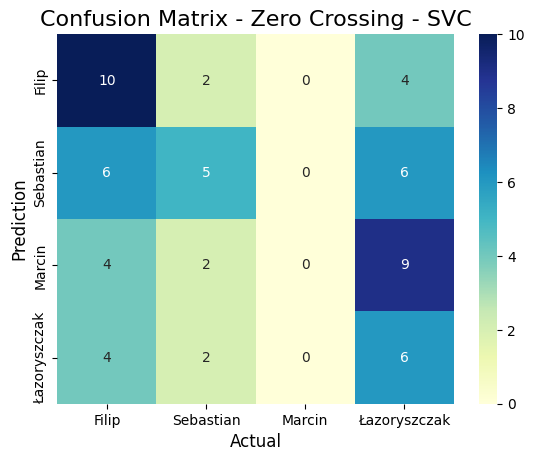

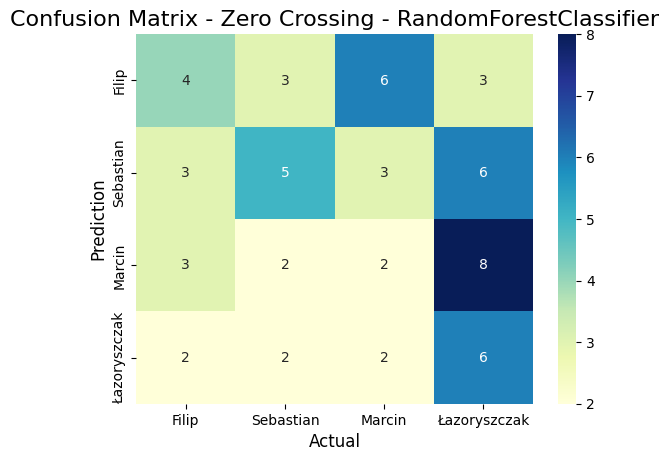

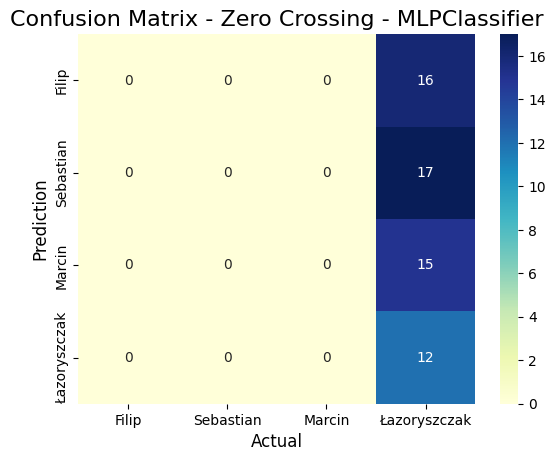

0.7333333333333333               precision    recall  f1-score   support

         0.0       0.62      0.81      0.70        16
         1.0       1.00      0.47      0.64        17
         2.0       0.85      0.73      0.79        15
         3.0       0.67      1.00      0.80        12

    accuracy                           0.73        60
   macro avg       0.78      0.75      0.73        60
weighted avg       0.79      0.73      0.73        60

0.7166666666666667               precision    recall  f1-score   support

         0.0       0.71      0.62      0.67        16
         1.0       0.69      0.65      0.67        17
         2.0       0.85      0.73      0.79        15
         3.0       0.65      0.92      0.76        12

    accuracy                           0.72        60
   macro avg       0.72      0.73      0.72        60
weighted avg       0.73      0.72      0.71        60

0.7833333333333333               precision    recall  f1-score   support

         0.0      

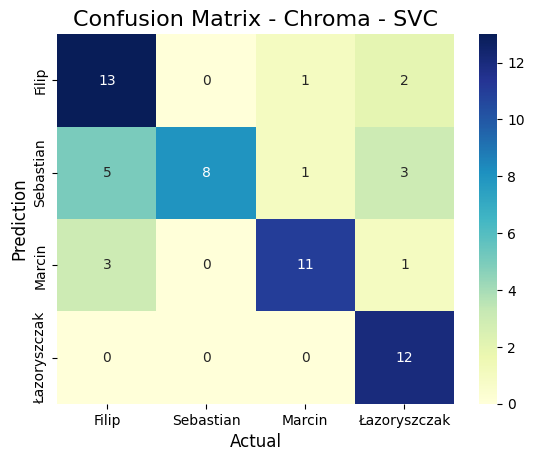

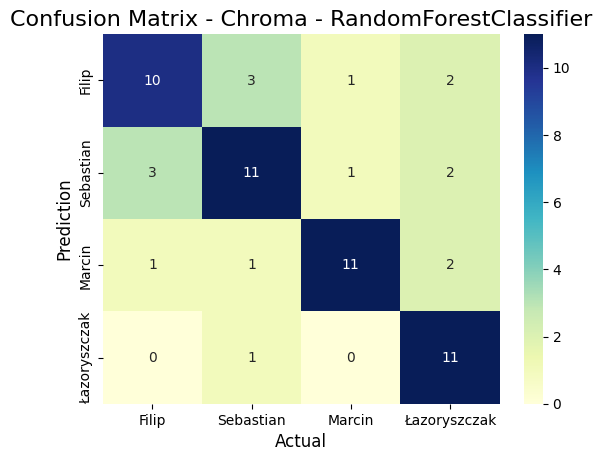

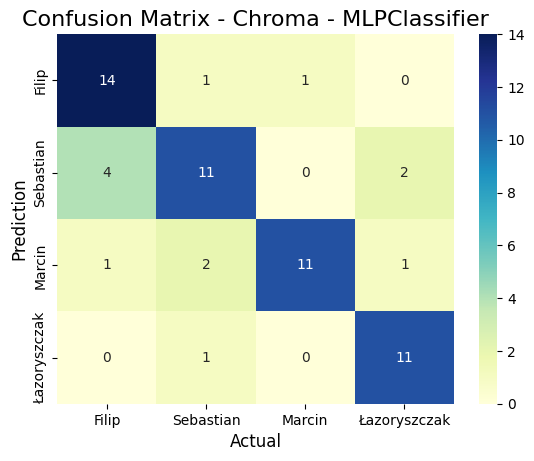

In [65]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 60%

In [66]:
noise_level = "N60"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.6666666666666666               precision    recall  f1-score   support

         0.0       0.58      0.69      0.63        16
         1.0       0.53      0.47      0.50        17
         2.0       0.67      0.67      0.67        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.67        60
   macro avg       0.69      0.69      0.69        60
weighted avg       0.67      0.67      0.67        60

0.5333333333333333               precision    recall  f1-score   support

         0.0       0.57      0.25

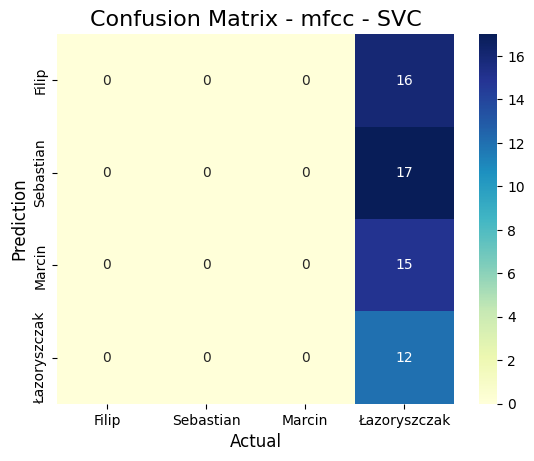

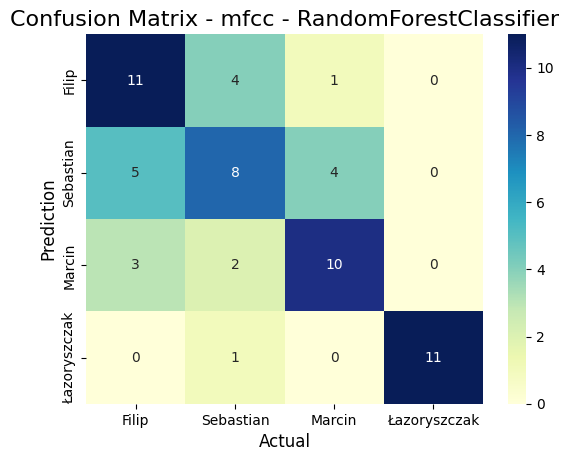

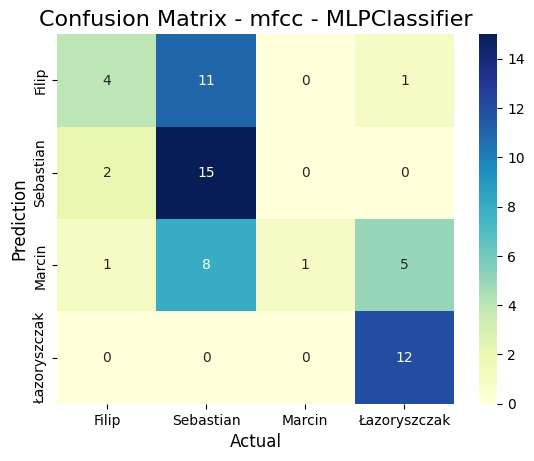

0.25               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.71      0.33      0.45        15
         3.0       0.19      0.83      0.31        12

    accuracy                           0.25        60
   macro avg       0.23      0.29      0.19        60
weighted avg       0.22      0.25      0.18        60

0.4               precision    recall  f1-score   support

         0.0       0.83      0.31      0.45        16
         1.0       0.33      0.35      0.34        17
         2.0       0.38      0.40      0.39        15
         3.0       0.35      0.58      0.44        12

    accuracy                           0.40        60
   macro avg       0.47      0.41      0.41        60
weighted avg       0.48      0.40      0.40        60

0.3               precision    recall  f1-score   support

         0.0       0.29      0.31      0.30        16
        

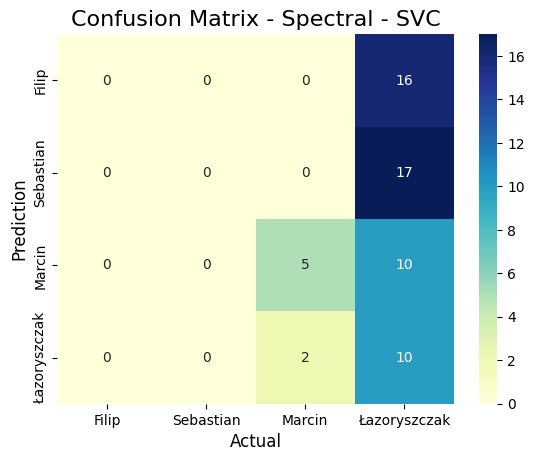

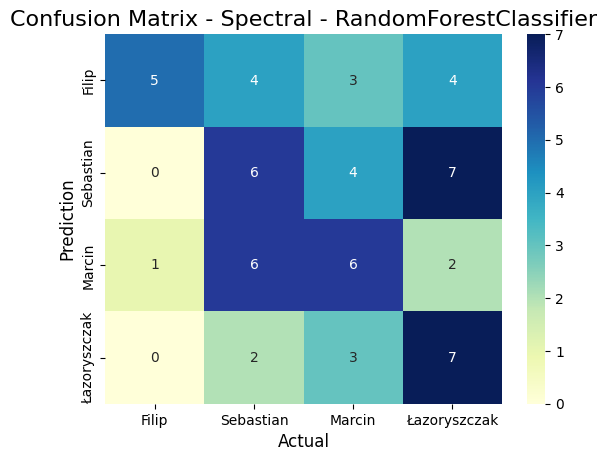

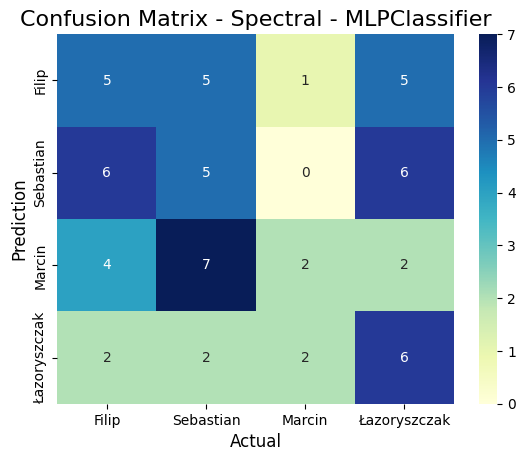

0.3333333333333333               precision    recall  f1-score   support

         0.0       0.39      0.56      0.46        16
         1.0       0.42      0.29      0.34        17
         2.0       0.00      0.00      0.00        15
         3.0       0.24      0.50      0.32        12

    accuracy                           0.33        60
   macro avg       0.26      0.34      0.28        60
weighted avg       0.27      0.33      0.29        60

0.2833333333333333               precision    recall  f1-score   support

         0.0       0.50      0.38      0.43        16
         1.0       0.27      0.18      0.21        17
         2.0       0.17      0.27      0.21        15
         3.0       0.29      0.33      0.31        12

    accuracy                           0.28        60
   macro avg       0.31      0.29      0.29        60
weighted avg       0.31      0.28      0.29        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00

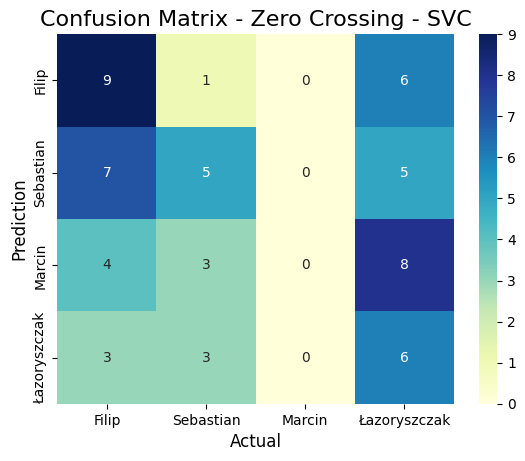

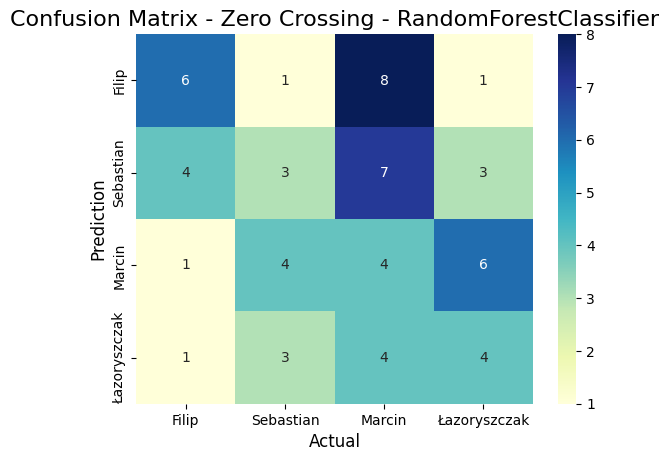

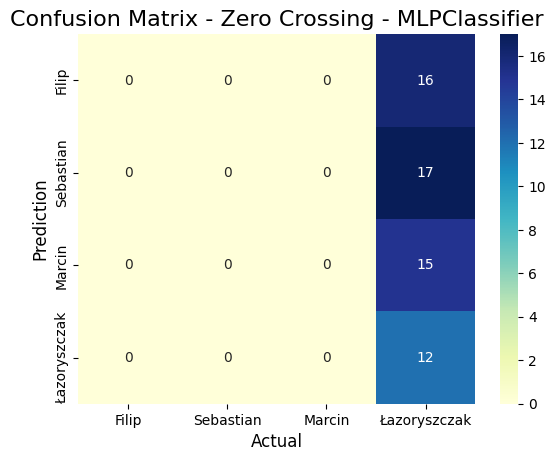

0.45               precision    recall  f1-score   support

         0.0       0.67      0.12      0.21        16
         1.0       0.00      0.00      0.00        17
         2.0       0.35      0.87      0.50        15
         3.0       0.60      1.00      0.75        12

    accuracy                           0.45        60
   macro avg       0.40      0.50      0.37        60
weighted avg       0.39      0.45      0.33        60

0.7166666666666667               precision    recall  f1-score   support

         0.0       0.71      0.75      0.73        16
         1.0       0.60      0.53      0.56        17
         2.0       0.80      0.80      0.80        15
         3.0       0.77      0.83      0.80        12

    accuracy                           0.72        60
   macro avg       0.72      0.73      0.72        60
weighted avg       0.71      0.72      0.71        60

0.75               precision    recall  f1-score   support

         0.0       0.68      0.81      0.74   

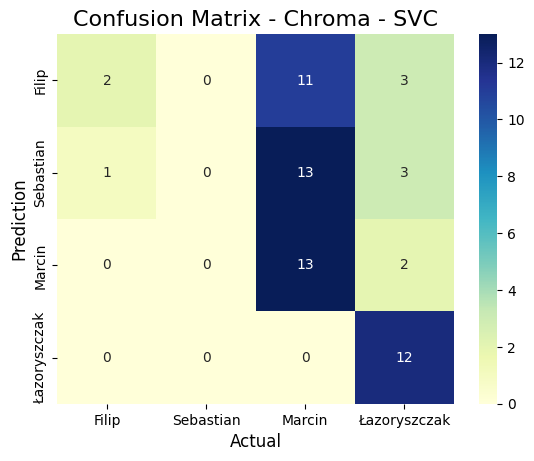

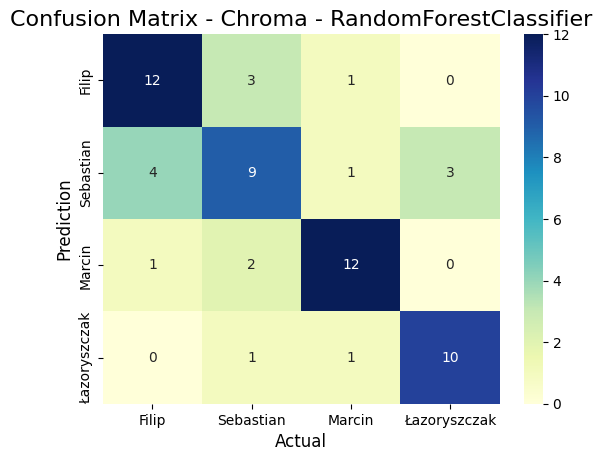

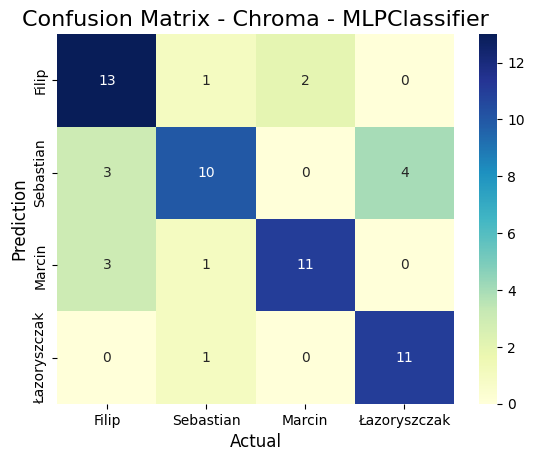

In [67]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 70%

In [68]:
noise_level = "N70"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.5833333333333334               precision    recall  f1-score   support

         0.0       0.45      0.56      0.50        16
         1.0       0.53      0.47      0.50        17
         2.0       0.64      0.60      0.62        15
         3.0       0.82      0.75      0.78        12

    accuracy                           0.58        60
   macro avg       0.61      0.60      0.60        60
weighted avg       0.60      0.58      0.59        60

0.2833333333333333               precision    recall  f1-score   support

         0.0       0.29      0.94

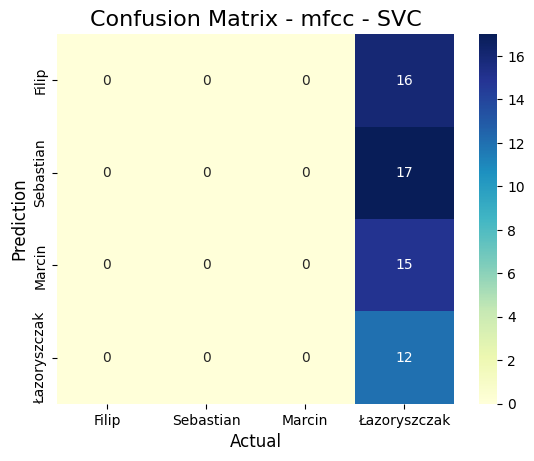

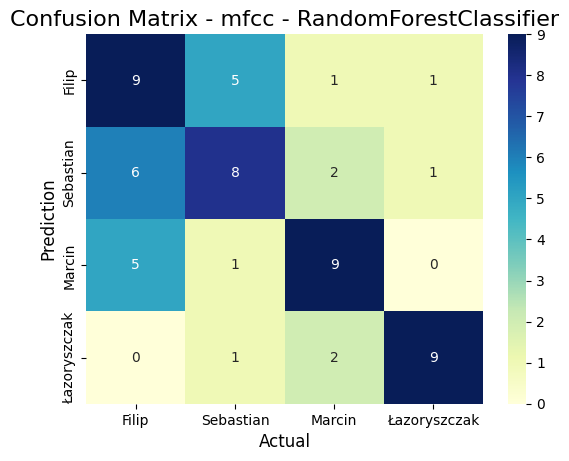

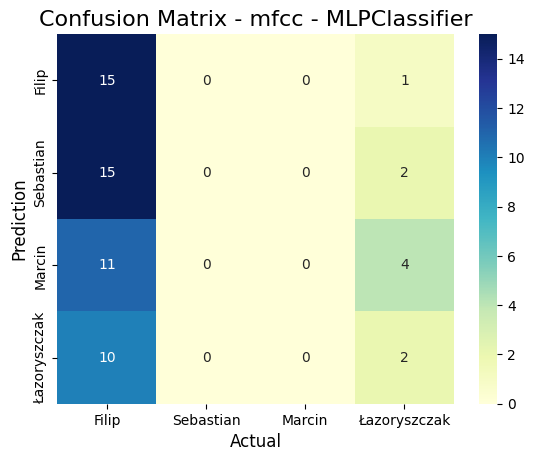

0.18333333333333332               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.33      0.07      0.11        15
         3.0       0.18      0.83      0.29        12

    accuracy                           0.18        60
   macro avg       0.13      0.23      0.10        60
weighted avg       0.12      0.18      0.09        60

0.4               precision    recall  f1-score   support

         0.0       0.67      0.38      0.48        16
         1.0       0.33      0.41      0.37        17
         2.0       0.67      0.27      0.38        15
         3.0       0.29      0.58      0.39        12

    accuracy                           0.40        60
   macro avg       0.49      0.41      0.40        60
weighted avg       0.50      0.40      0.41        60

0.26666666666666666               precision    recall  f1-score   support

         0.0       0.25      0.

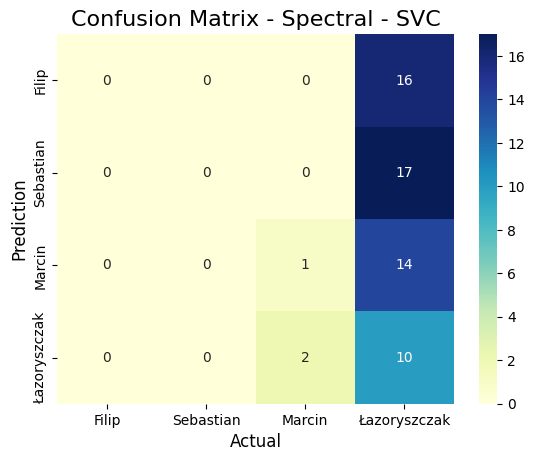

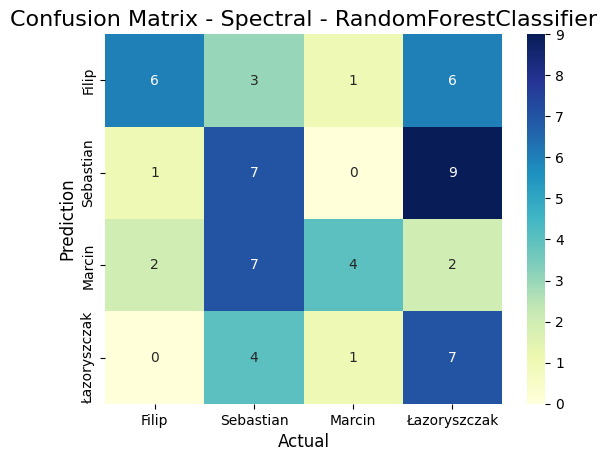

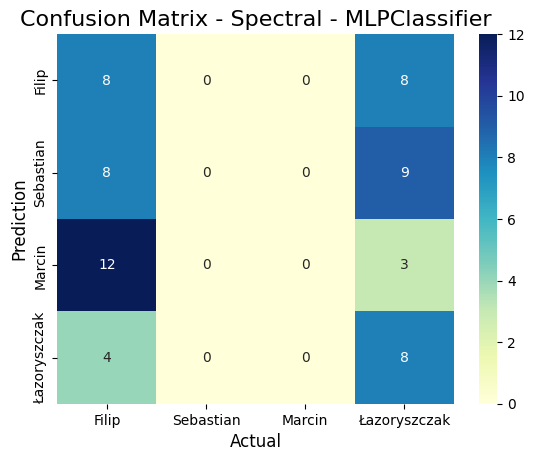

0.4               precision    recall  f1-score   support

         0.0       0.37      0.44      0.40        16
         1.0       0.43      0.35      0.39        17
         2.0       0.50      0.40      0.44        15
         3.0       0.33      0.42      0.37        12

    accuracy                           0.40        60
   macro avg       0.41      0.40      0.40        60
weighted avg       0.41      0.40      0.40        60

0.38333333333333336               precision    recall  f1-score   support

         0.0       0.47      0.44      0.45        16
         1.0       0.40      0.47      0.43        17
         2.0       0.50      0.47      0.48        15
         3.0       0.09      0.08      0.09        12

    accuracy                           0.38        60
   macro avg       0.36      0.36      0.36        60
weighted avg       0.38      0.38      0.38        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    

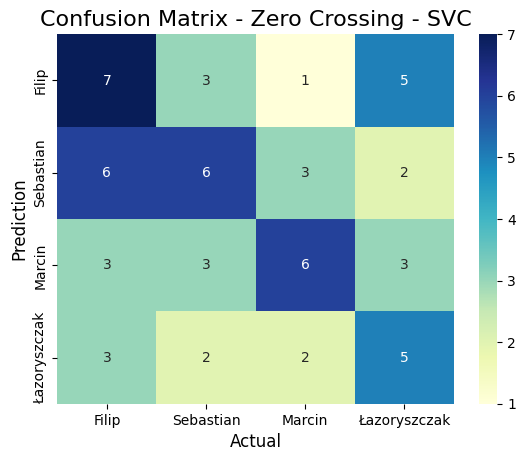

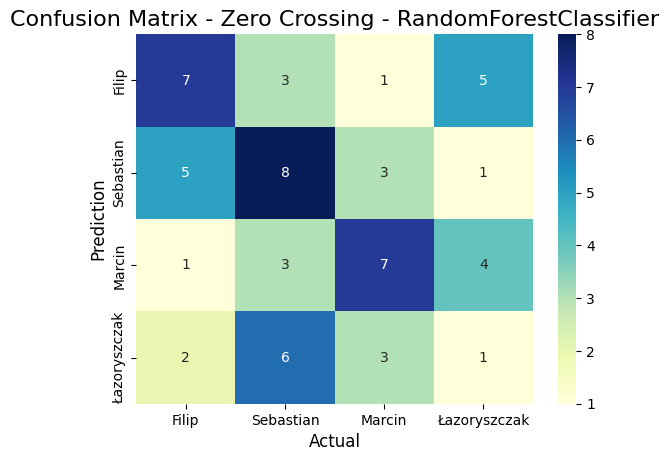

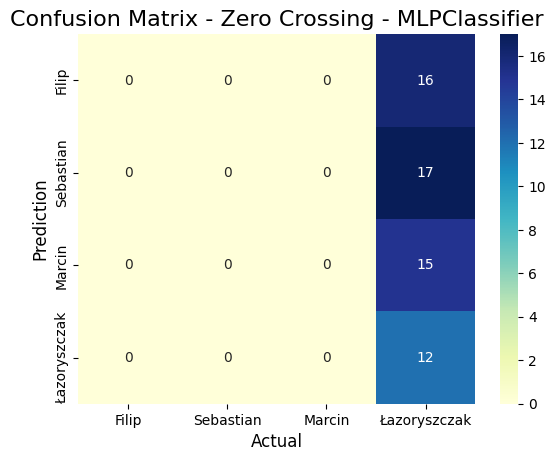

0.45               precision    recall  f1-score   support

         0.0       0.44      0.75      0.56        16
         1.0       0.00      0.00      0.00        17
         2.0       0.60      0.20      0.30        15
         3.0       0.43      1.00      0.60        12

    accuracy                           0.45        60
   macro avg       0.37      0.49      0.36        60
weighted avg       0.35      0.45      0.34        60

0.65               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67        16
         1.0       0.56      0.53      0.55        17
         2.0       0.82      0.60      0.69        15
         3.0       0.62      0.83      0.71        12

    accuracy                           0.65        60
   macro avg       0.66      0.66      0.65        60
weighted avg       0.66      0.65      0.65        60

0.5166666666666667               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00   

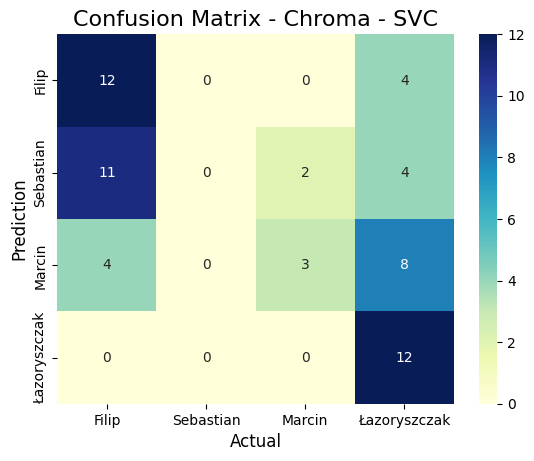

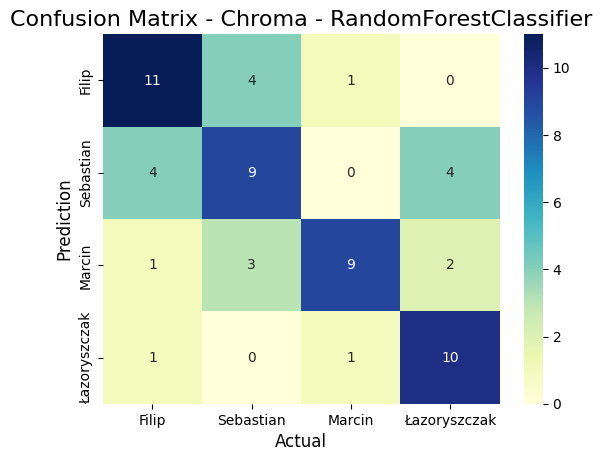

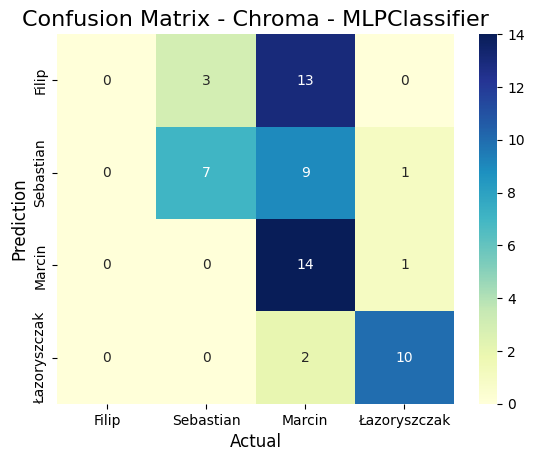

In [69]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Nosie - 80 %

In [70]:
noise_level = "N80"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.6               precision    recall  f1-score   support

         0.0       0.60      0.75      0.67        16
         1.0       0.58      0.41      0.48        17
         2.0       0.50      0.60      0.55        15
         3.0       0.80      0.67      0.73        12

    accuracy                           0.60        60
   macro avg       0.62      0.61      0.61        60
weighted avg       0.61      0.60      0.60        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         

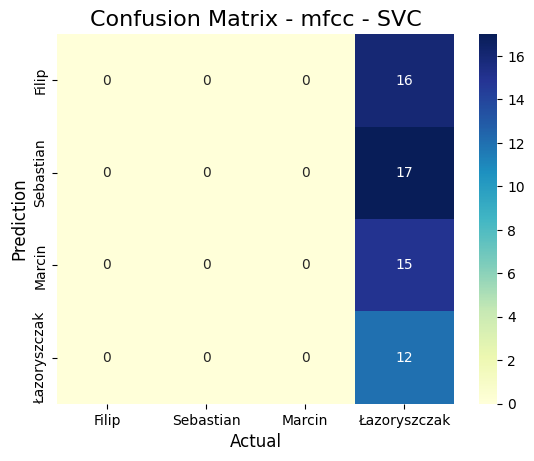

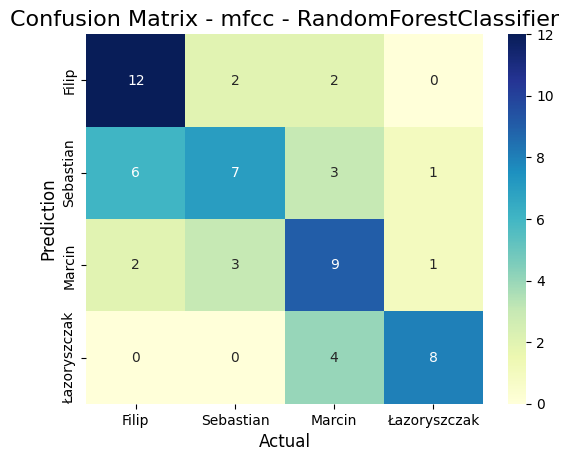

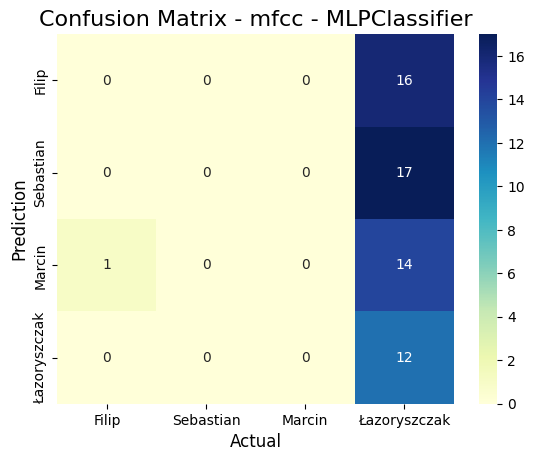

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.4               precision    recall  f1-score   support

         0.0       0.57      0.50      0.53        16
         1.0       0.25      0.18      0.21        17
         2.0       0.56      0.33      0.42        15
         3.0       0.32      0.67      0.43        12

    accuracy                           0.40        60
   macro avg       0.42      0.42      0.40        60
weighted avg       0.43      0.40      0.39        60

0.16666666666666666               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    

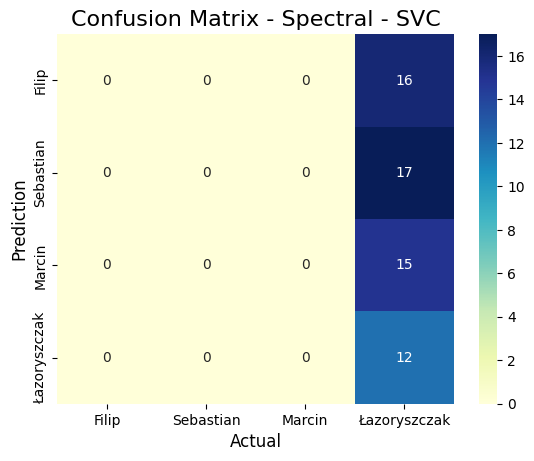

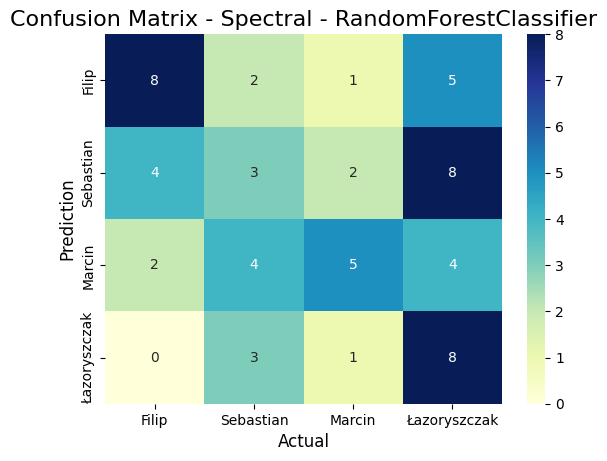

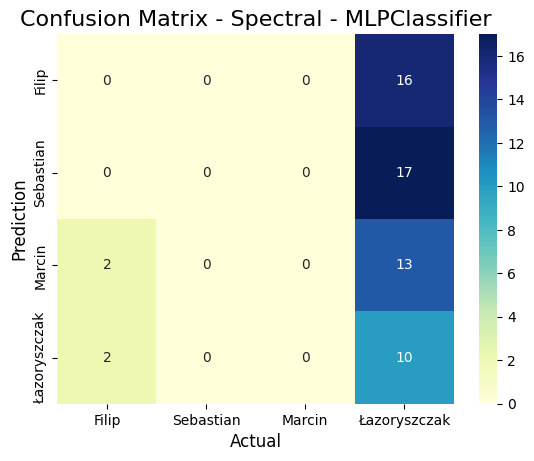

0.4               precision    recall  f1-score   support

         0.0       0.39      0.44      0.41        16
         1.0       0.40      0.35      0.38        17
         2.0       0.54      0.47      0.50        15
         3.0       0.29      0.33      0.31        12

    accuracy                           0.40        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.41      0.40      0.40        60

0.4               precision    recall  f1-score   support

         0.0       0.37      0.44      0.40        16
         1.0       0.45      0.53      0.49        17
         2.0       0.50      0.40      0.44        15
         3.0       0.22      0.17      0.19        12

    accuracy                           0.40        60
   macro avg       0.39      0.38      0.38        60
weighted avg       0.40      0.40      0.39        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         

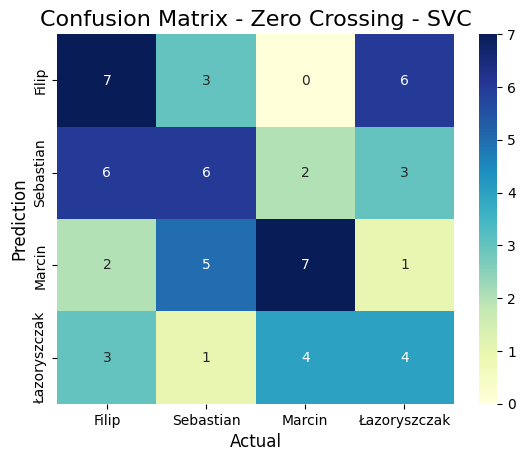

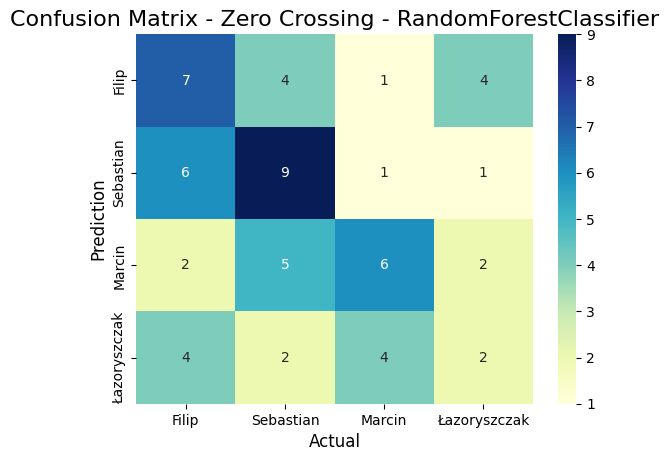

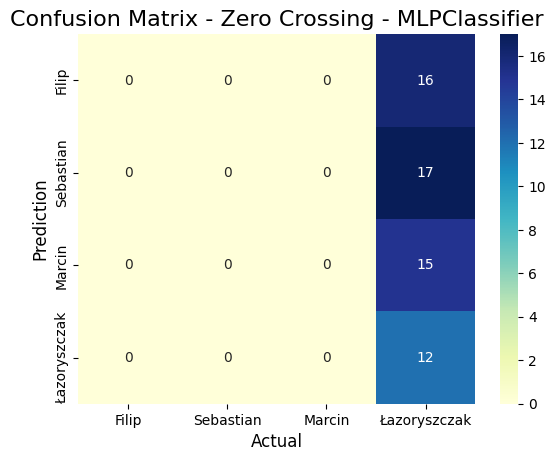

0.36666666666666664               precision    recall  f1-score   support

         0.0       0.43      0.62      0.51        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.32      1.00      0.49        12

    accuracy                           0.37        60
   macro avg       0.19      0.41      0.25        60
weighted avg       0.18      0.37      0.23        60

0.5166666666666667               precision    recall  f1-score   support

         0.0       0.47      0.50      0.48        16
         1.0       0.27      0.24      0.25        17
         2.0       0.59      0.67      0.62        15
         3.0       0.82      0.75      0.78        12

    accuracy                           0.52        60
   macro avg       0.54      0.54      0.54        60
weighted avg       0.51      0.52      0.51        60

0.65               precision    recall  f1-score   support

         0.0       0.58      0.

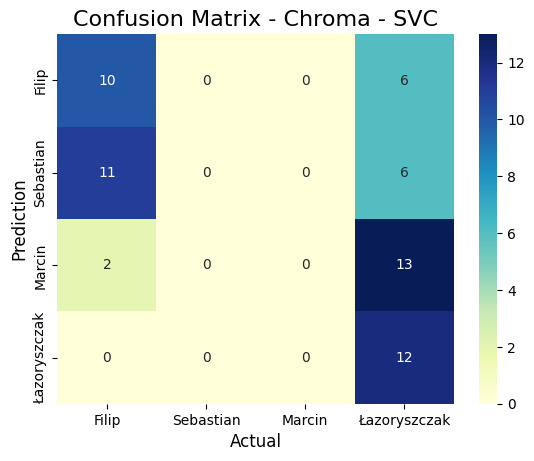

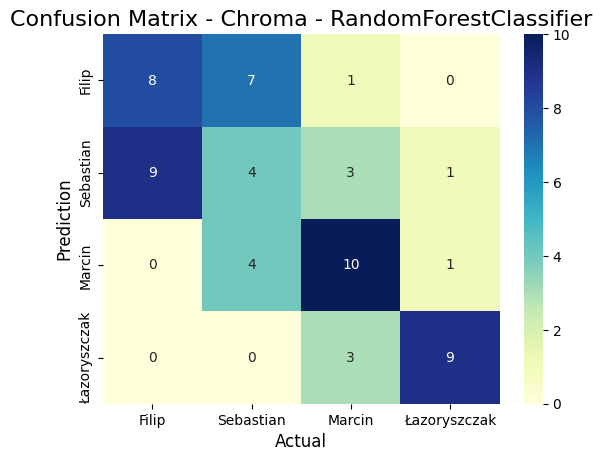

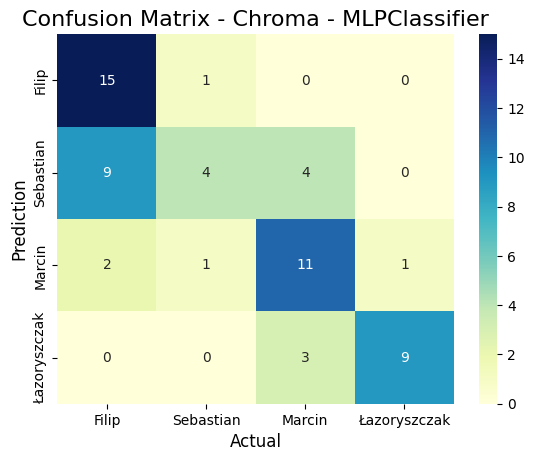

In [71]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")

# Noise - 90 %

In [72]:
noise_level = "N90"

words_filip = load_noise_data(FILIP_PATH,noise_level,no_of_words, "F")
words_seb = load_noise_data(SEB_PATH,noise_level,no_of_words, "S")
words_marcin = load_noise_data(MARCIN_PATH,noise_level,no_of_words, "M")
words_prof = load_noise_data(PROF_PATH,noise_level,no_of_words, "L")


mfcc_features_no = 13
spectral_features_no = 4

feature_vector_mfcc = get_feature_vector_mfcc(words_filip,words_seb,words_marcin,words_prof,no_of_words, mfcc_features_no)
feature_vector_spectral = get_feature_vector_spectral(words_filip,words_seb,words_marcin,words_prof,no_of_words, spectral_features_no)
feature_vector_zeros = get_feature_vector_zeros(words_filip, words_seb,words_marcin,words_prof,no_of_words)
feature_vector_chroma = get_feature_vector_chroma(words_filip, words_seb,words_marcin,words_prof,chroma_types)

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.5166666666666667               precision    recall  f1-score   support

         0.0       0.47      0.56      0.51        16
         1.0       0.38      0.29      0.33        17
         2.0       0.53      0.67      0.59        15
         3.0       0.78      0.58      0.67        12

    accuracy                           0.52        60
   macro avg       0.54      0.53      0.53        60
weighted avg       0.52      0.52      0.51        60

0.5               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50     

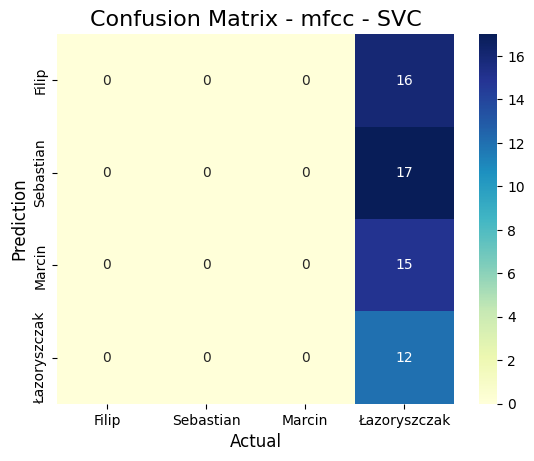

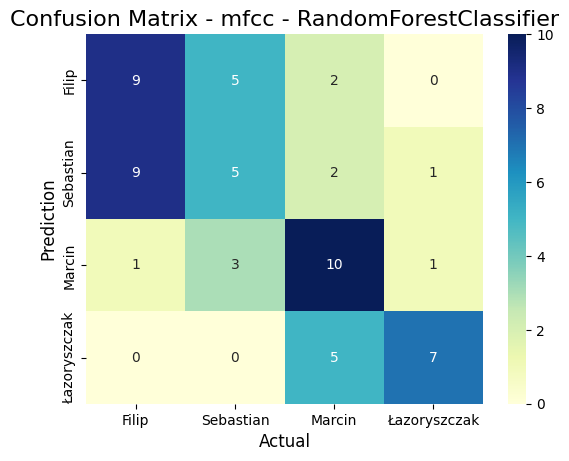

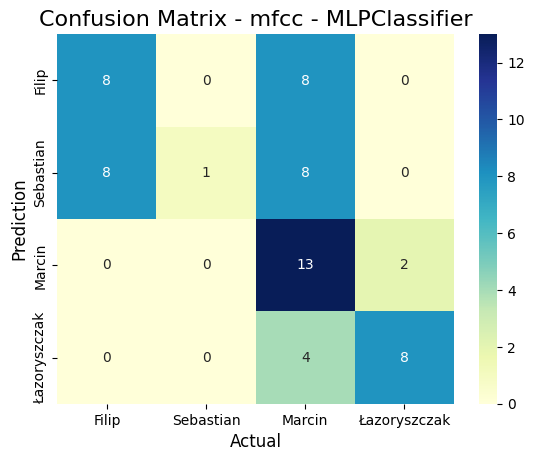

0.2               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.20      1.00      0.33        12

    accuracy                           0.20        60
   macro avg       0.05      0.25      0.08        60
weighted avg       0.04      0.20      0.07        60

0.5666666666666667               precision    recall  f1-score   support

         0.0       0.54      0.44      0.48        16
         1.0       0.50      0.53      0.51        17
         2.0       0.71      0.67      0.69        15
         3.0       0.53      0.67      0.59        12

    accuracy                           0.57        60
   macro avg       0.57      0.58      0.57        60
weighted avg       0.57      0.57      0.57        60

0.38333333333333336               precision    recall  f1-score   support

         0.0       0.31      0.6

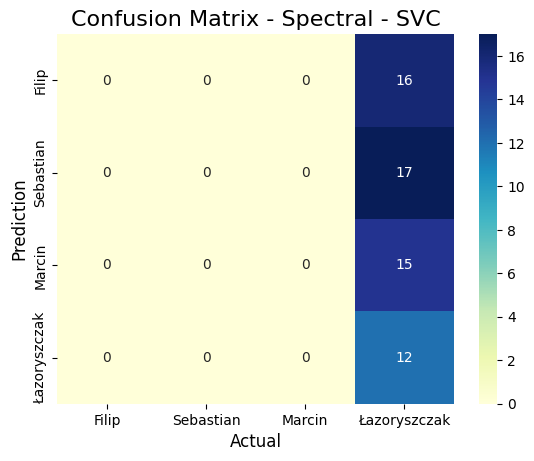

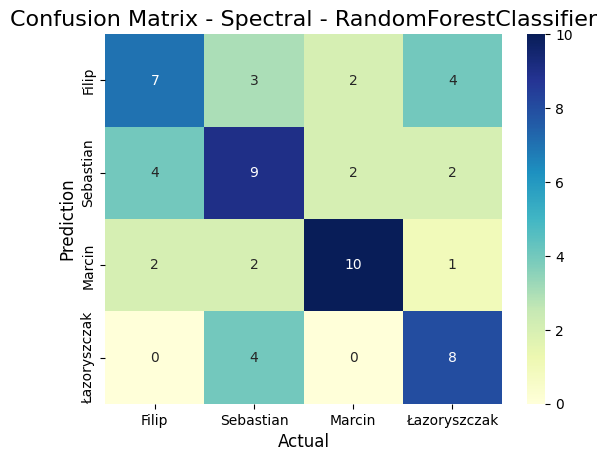

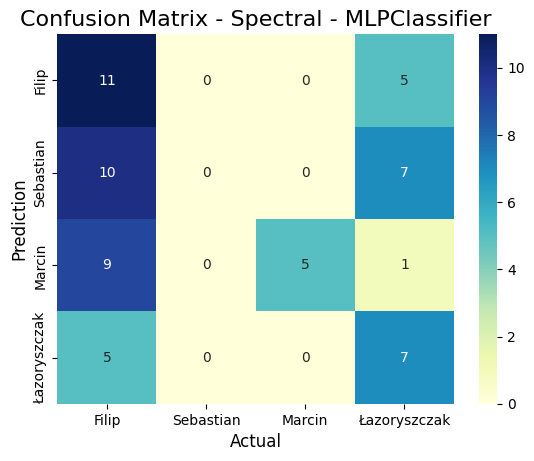

0.43333333333333335               precision    recall  f1-score   support

         0.0       0.40      0.38      0.39        16
         1.0       0.44      0.47      0.46        17
         2.0       0.58      0.47      0.52        15
         3.0       0.33      0.42      0.37        12

    accuracy                           0.43        60
   macro avg       0.44      0.43      0.43        60
weighted avg       0.45      0.43      0.44        60

0.4666666666666667               precision    recall  f1-score   support

         0.0       0.48      0.62      0.54        16
         1.0       0.53      0.59      0.56        17
         2.0       0.60      0.20      0.30        15
         3.0       0.33      0.42      0.37        12

    accuracy                           0.47        60
   macro avg       0.48      0.46      0.44        60
weighted avg       0.49      0.47      0.45        60

0.2               precision    recall  f1-score   support

         0.0       0.00      0.0

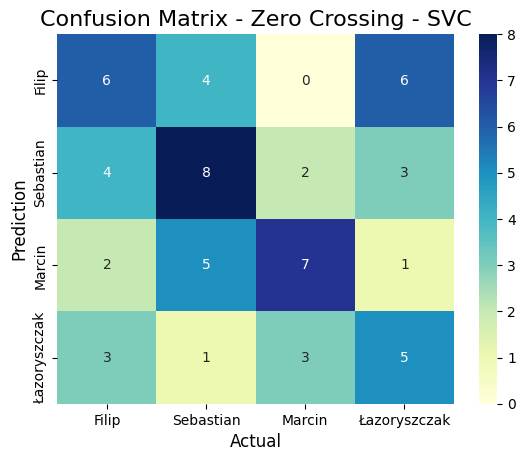

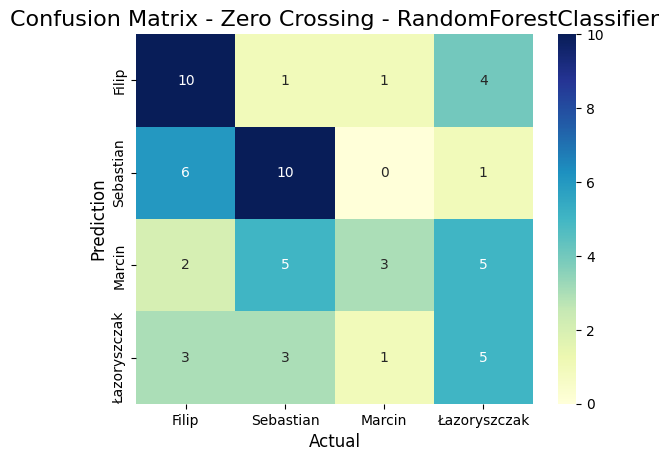

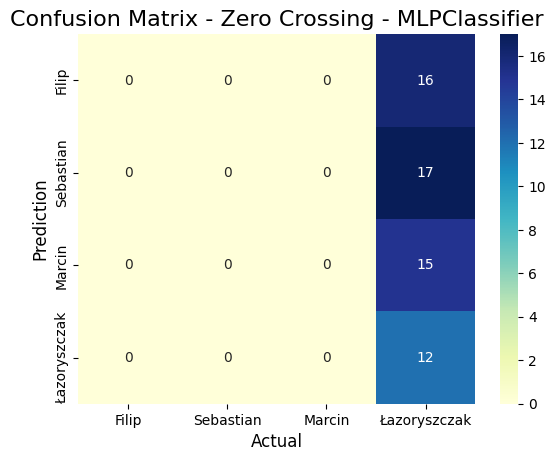

0.35               precision    recall  f1-score   support

         0.0       0.45      0.56      0.50        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.30      1.00      0.46        12

    accuracy                           0.35        60
   macro avg       0.19      0.39      0.24        60
weighted avg       0.18      0.35      0.23        60

0.48333333333333334               precision    recall  f1-score   support

         0.0       0.44      0.44      0.44        16
         1.0       0.33      0.35      0.34        17
         2.0       0.53      0.53      0.53        15
         3.0       0.73      0.67      0.70        12

    accuracy                           0.48        60
   macro avg       0.51      0.50      0.50        60
weighted avg       0.49      0.48      0.49        60

0.48333333333333334               precision    recall  f1-score   support

         0.0       0.44      0

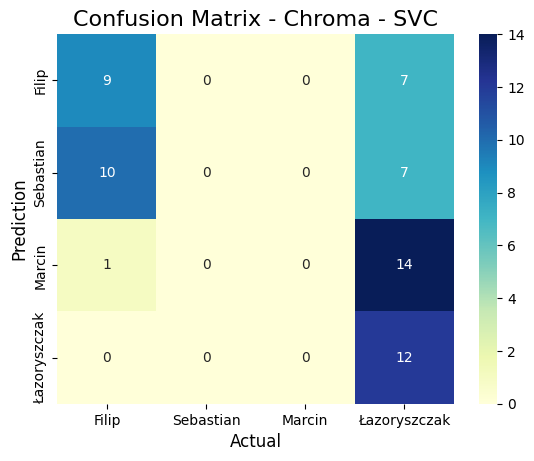

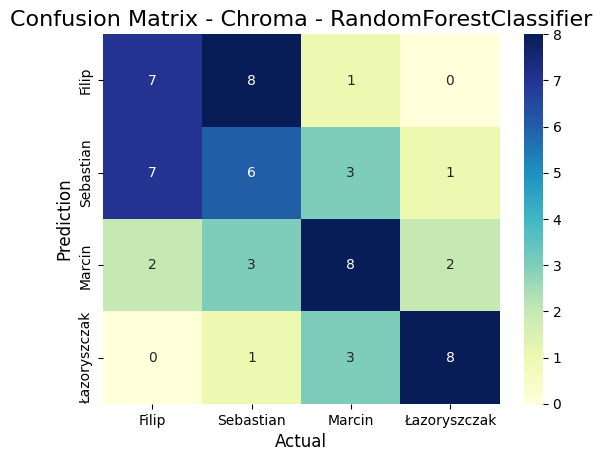

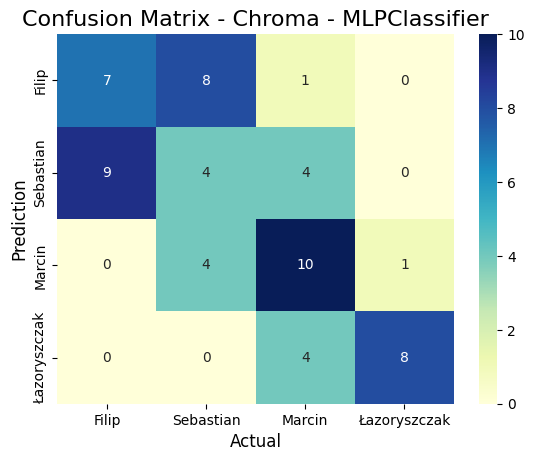

In [73]:
get_results_per_feature(feature_vector_mfcc,"mfcc")
get_results_per_feature(feature_vector_spectral,"Spectral")
get_results_per_feature(feature_vector_zeros,"Zero Crossing")
get_results_per_feature(feature_vector_chroma,"Chroma")